# Connect to google account

In [8]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [9]:
# 코렙 한글깨짐 방지
!apt -qq -y install fonts-nanum > /dev/null

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name()
# fm._rebuild()


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# Global Variables

In [10]:
import easydict
from easydict import EasyDict
import json
args = easydict.EasyDict()



# path 정보
args.default_path = '/content/data/MyDrive/AI_study/1. Machine Learning/Projects/kaggle/titanic/copy2/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_ang.csv'
args.save_results = args.default_path+"result/model_results.json"

args.random_state = 21 # seed key를 무조건 고정해야한다.
args.results = []

# Load Tritanic

- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- Sex:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [12]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [13]:
ori_train['passengerid'].nunique(), ori_train.shape[0]

(916, 916)

In [14]:
ori_train.drop('passengerid', axis=1, inplace=True)
ori_train.shape

(916, 11)

In [15]:
ori_test.set_index(['passengerid'], inplace=True)
ori_test.shape

(393, 10)



```
# 코드로 형식 지정됨
```

# ModelV5

In [16]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 11), (393, 10))

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train, test = train_test_split(ori_tr, test_size=0.3, stratify=ori_tr['survived'], random_state=args.random_state)

train.shape, test.shape

((641, 11), (275, 11))

- cabin: 학습에 도움이 안됨!!, 삭제 필요!!

In [19]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 10), (275, 10), (393, 9))

## Feature Extraction with EDA

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 641 entries, 812 to 277
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  641 non-null    int64  
 1   pclass    641 non-null    int64  
 2   name      641 non-null    object 
 3   gender    641 non-null    object 
 4   age       512 non-null    float64
 5   sibsp     641 non-null    int64  
 6   parch     641 non-null    int64  
 7   ticket    641 non-null    object 
 8   fare      641 non-null    float64
 9   embarked  641 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 55.1+ KB


### continous features

In [21]:
continous_cols = ['age', 'fare'] + ['survived']

train[continous_cols].describe()

,age,fare,survived
count,512.000000,641.000000,641.000000
mean,30.344082,31.654446,0.377535
std,14.492658,49.827609,0.485149
min,0.170000,0.000000,0.000000
25%,21.000000,7.895800,0.000000
50%,28.000000,14.400000,0.000000
75%,38.000000,30.000000,1.000000
max,80.000000,512.329200,1.000000


In [22]:
train[continous_cols].corr()

,age,fare,survived
age,1.000000,0.125341,-0.025265
fare,0.125341,1.000000,0.232942
survived,-0.025265,0.232942,1.000000


age

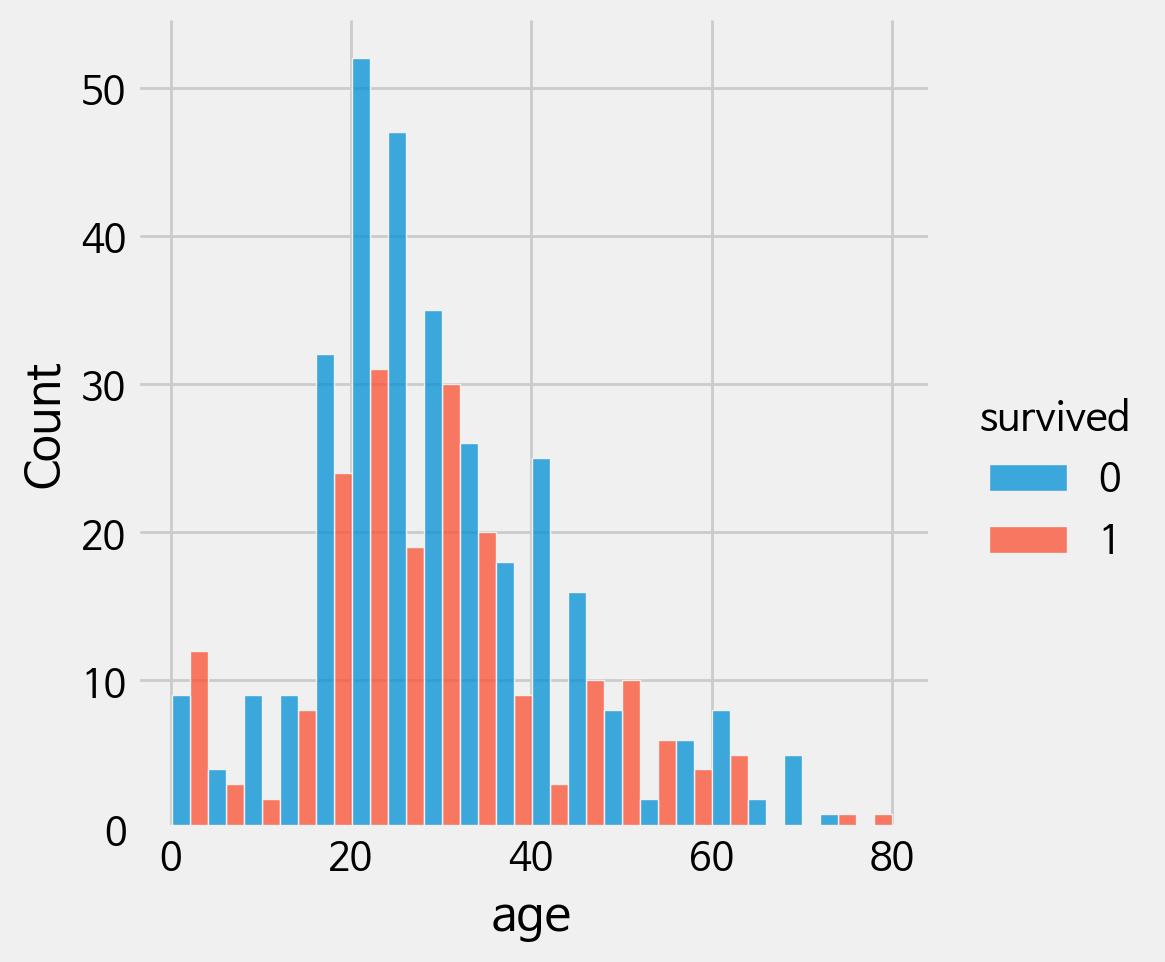

In [23]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [24]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5652173913043478

In [25]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.16666666666666666

In [26]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3783231083844581

add infant

In [27]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

2 / 
 [0 1] 



((641, 11), (275, 11), (393, 10))

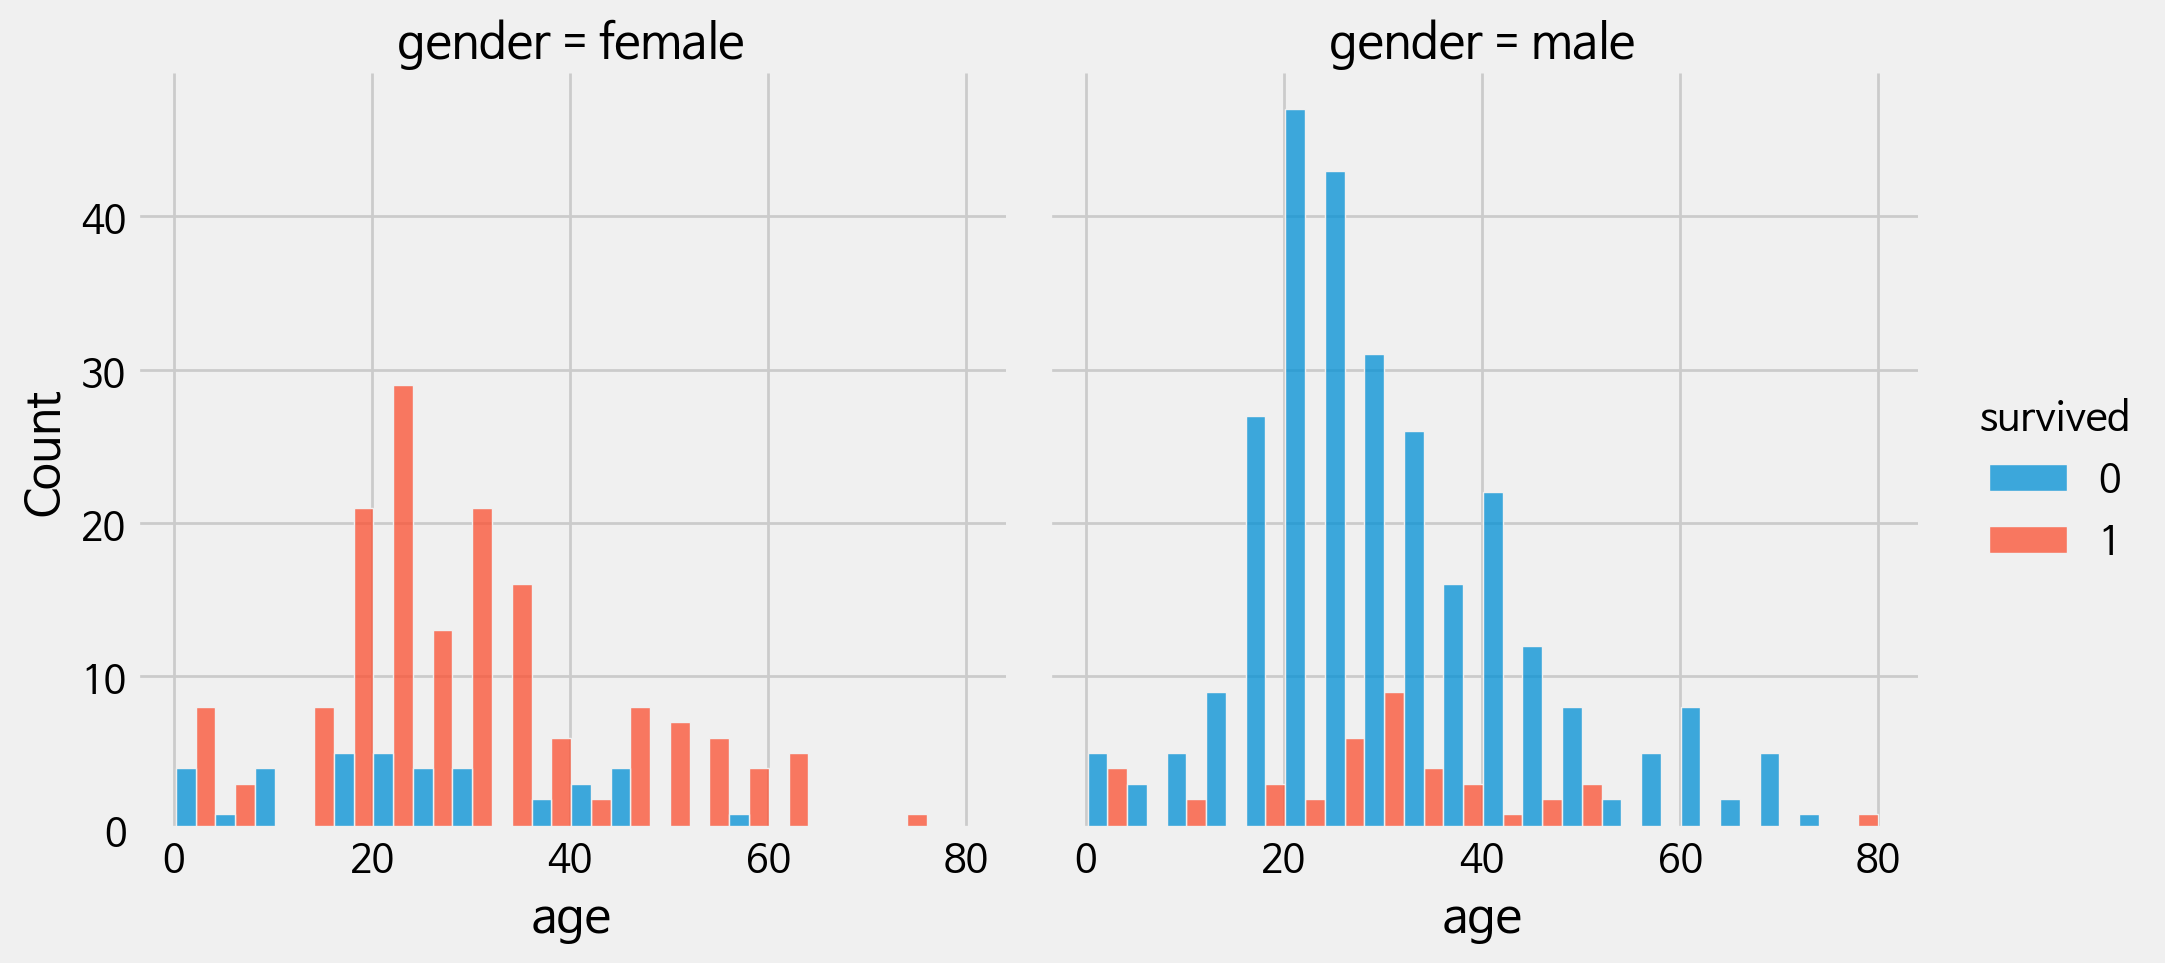

In [28]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

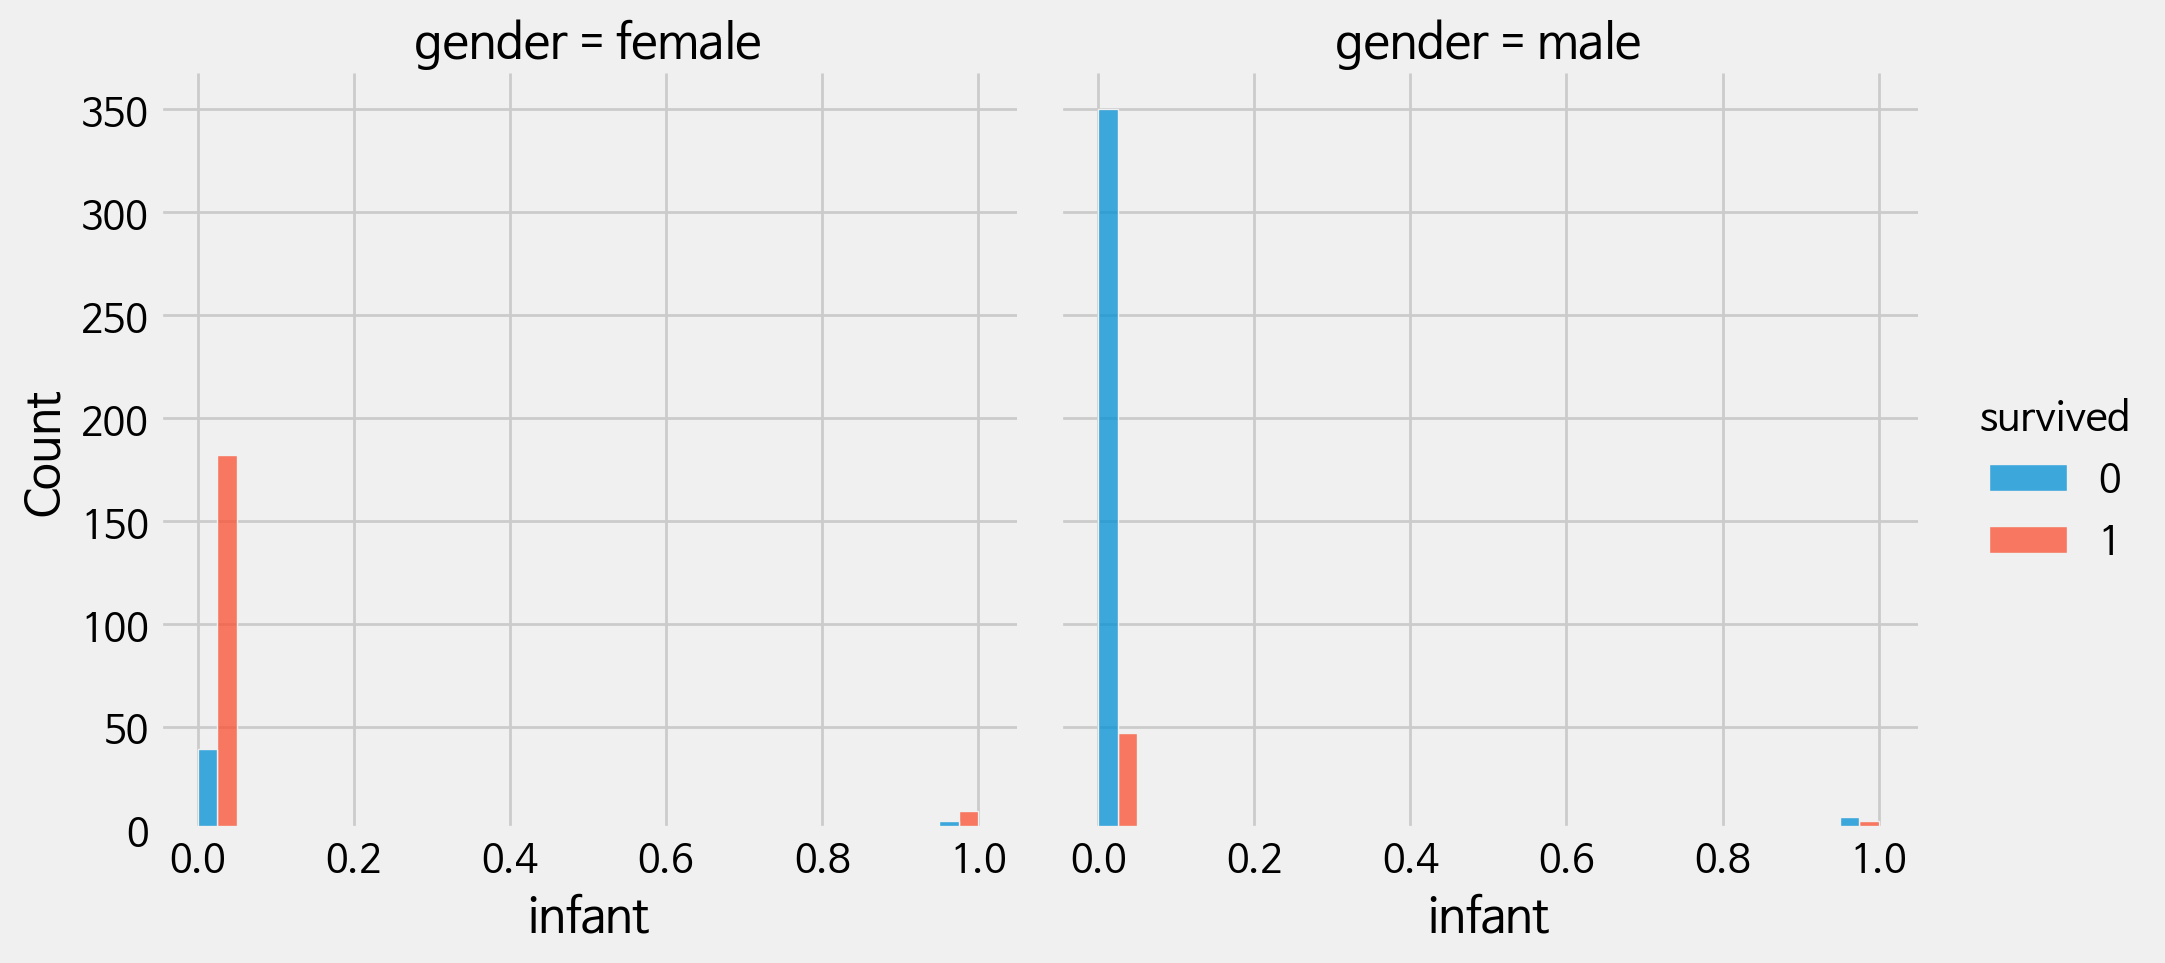

In [29]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

add gender_infant

In [30]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['female_0' 'male_0' 'female_1' 'male_1'] 



((641, 12), (275, 12), (393, 11))

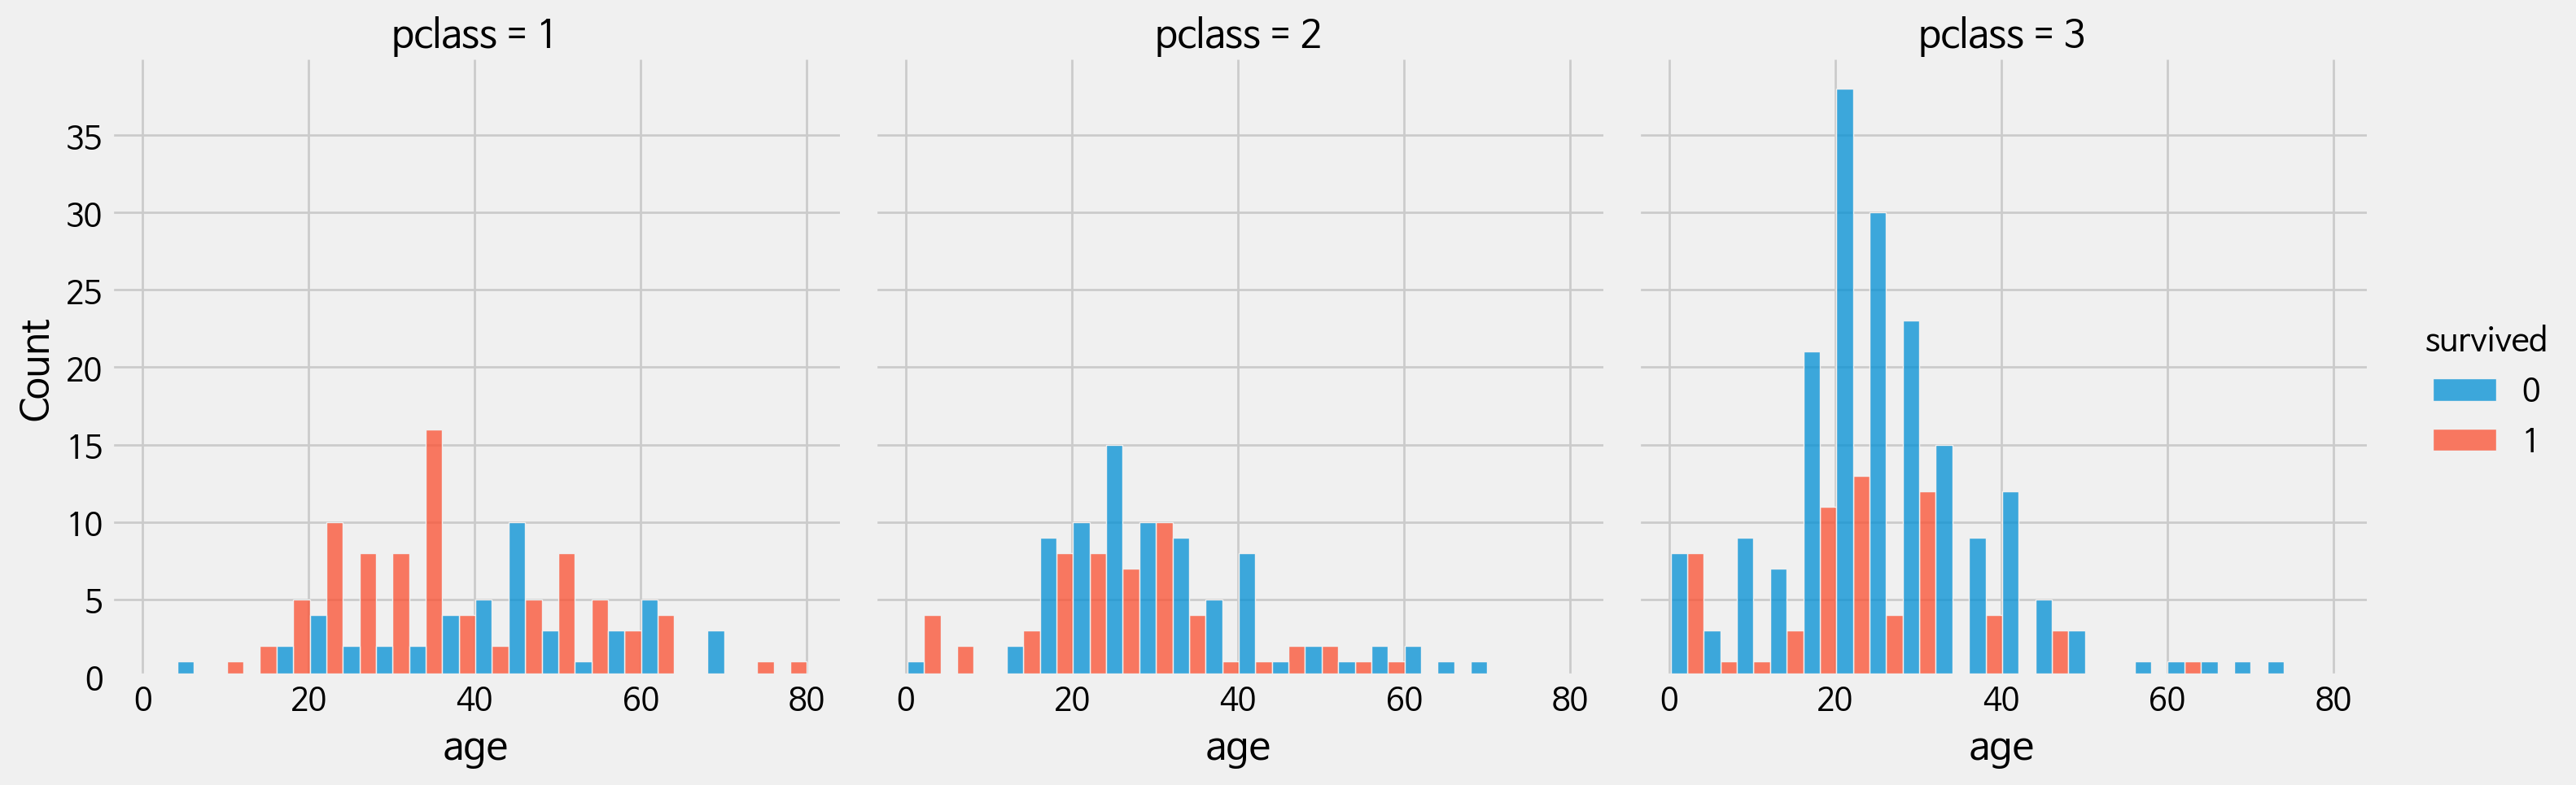

In [31]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")

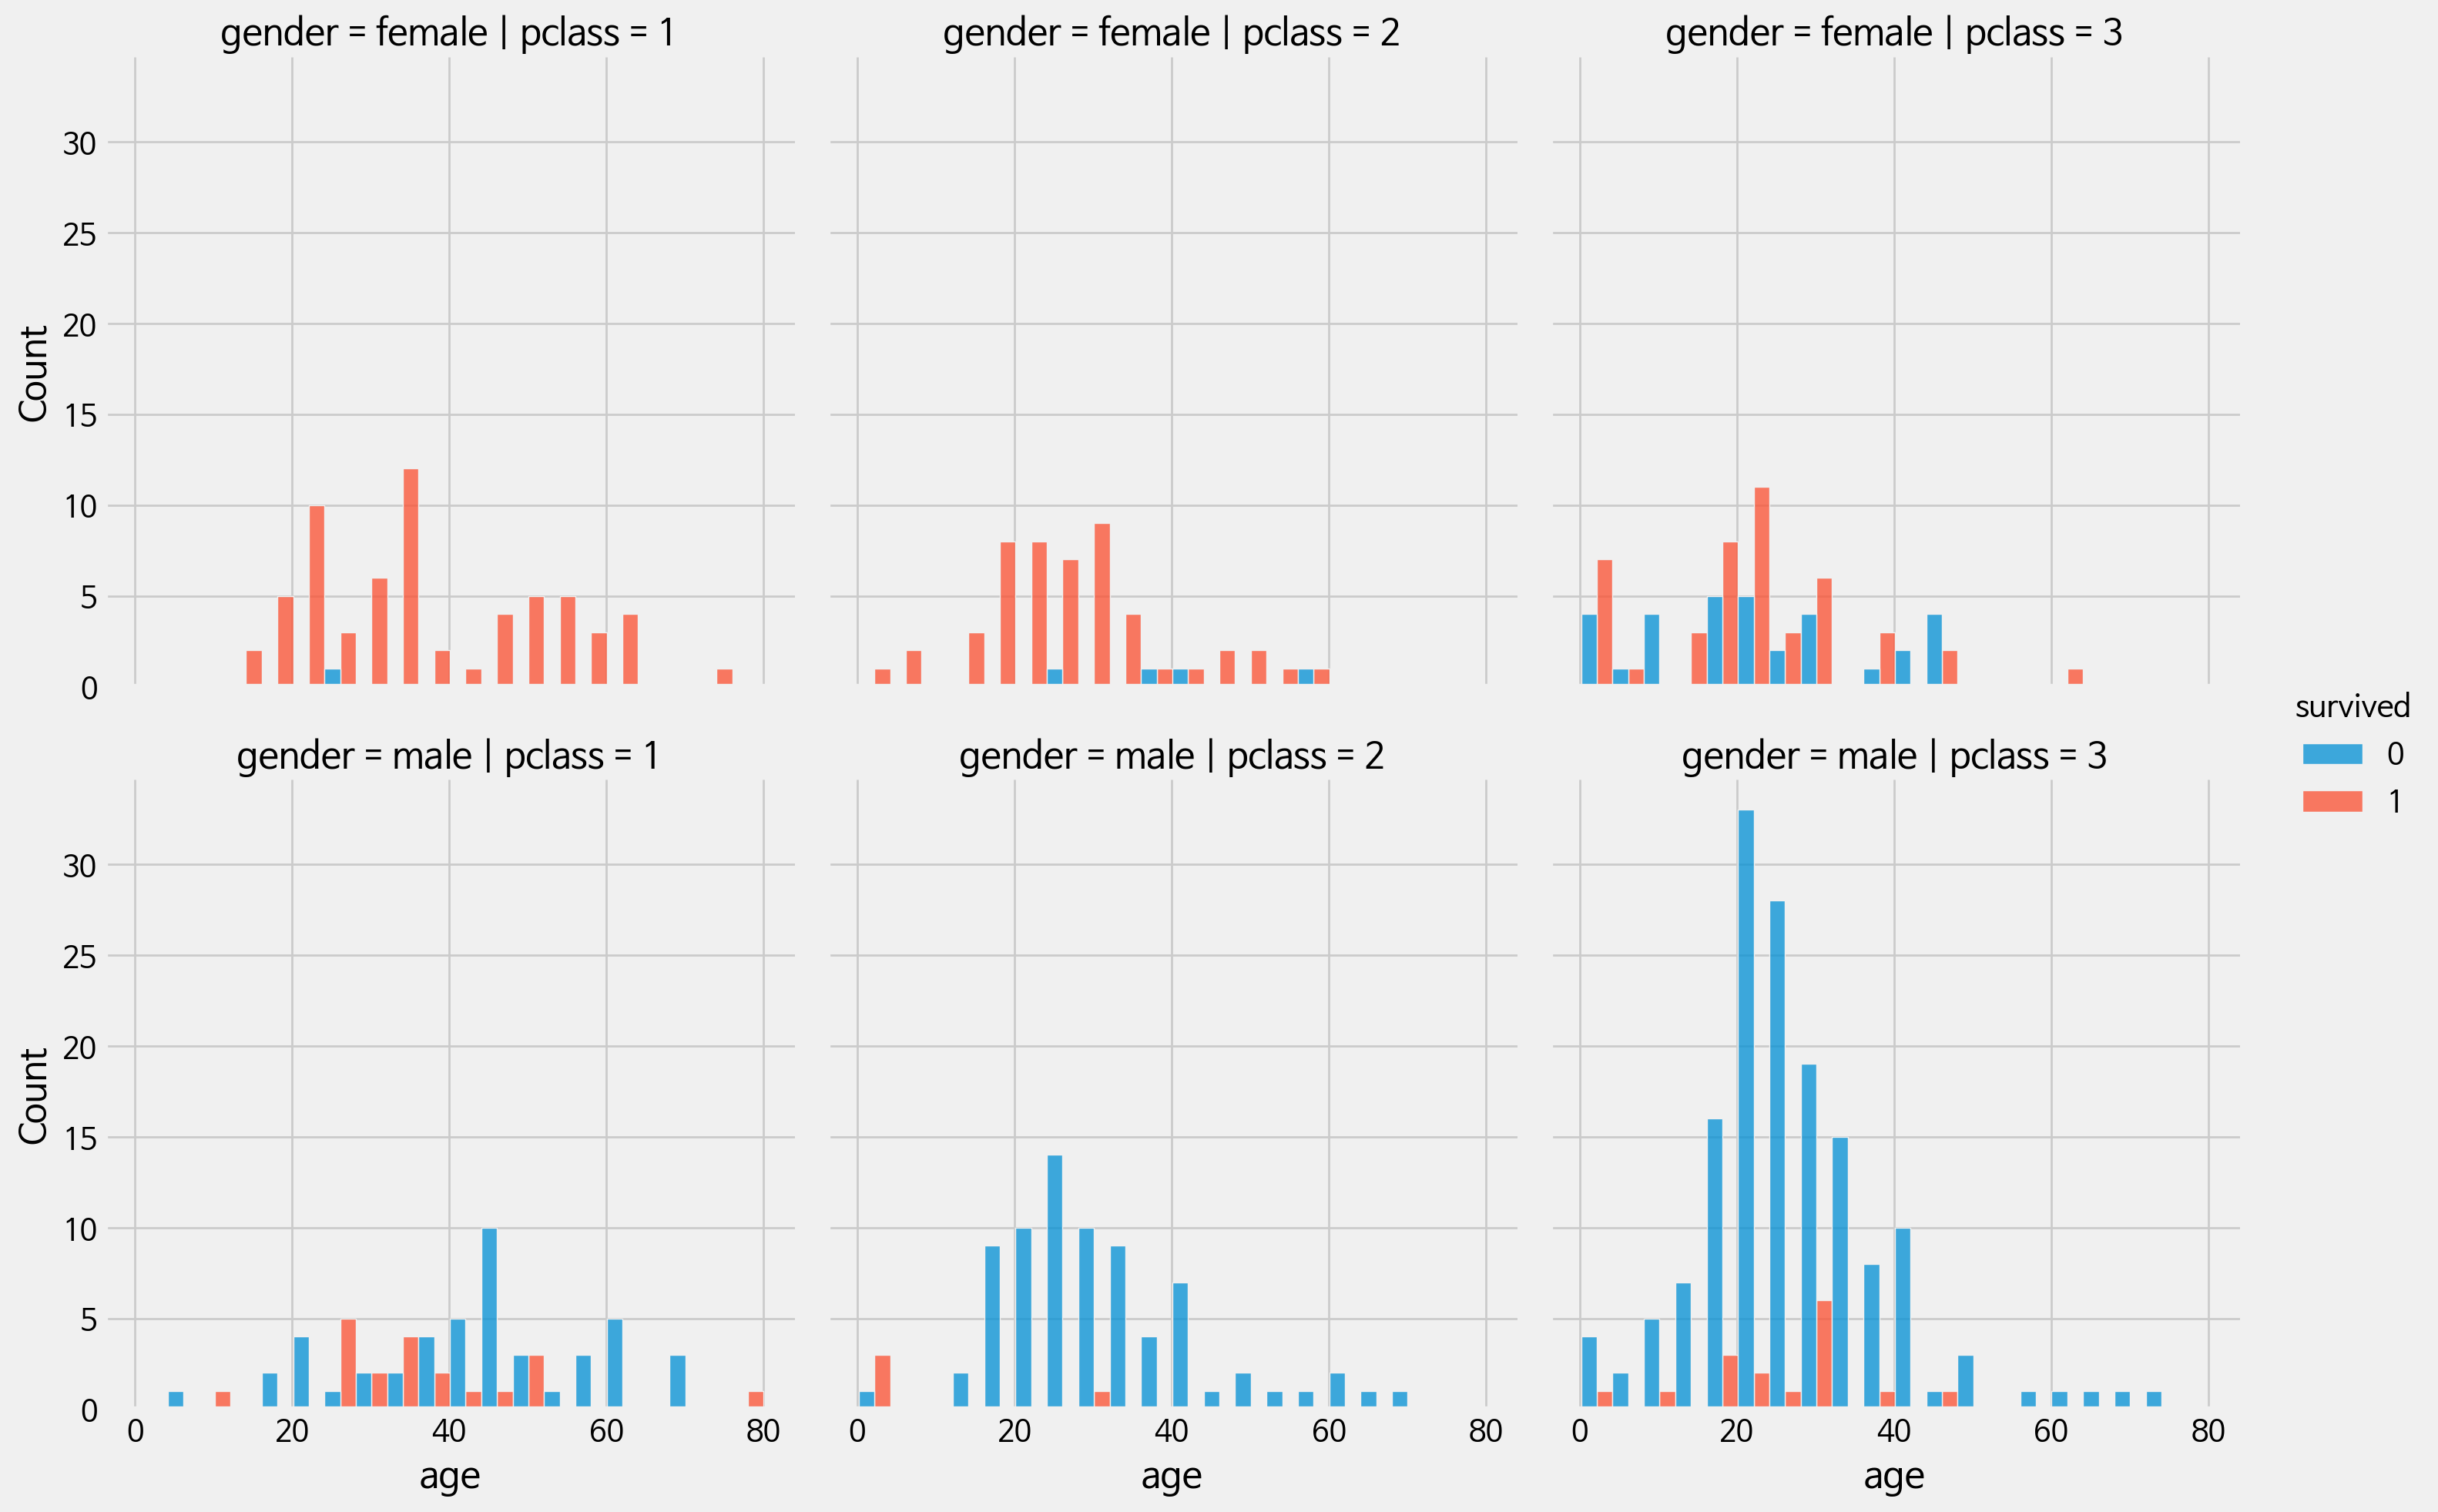

In [32]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

add gender_pclass

In [33]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"{train['gender_pclass'].nunique()} / \n {train['gender_pclass'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['female_3' 'male_3' 'female_2' 'male_1' 'female_1' 'male_2'] 



((641, 13), (275, 13), (393, 12))

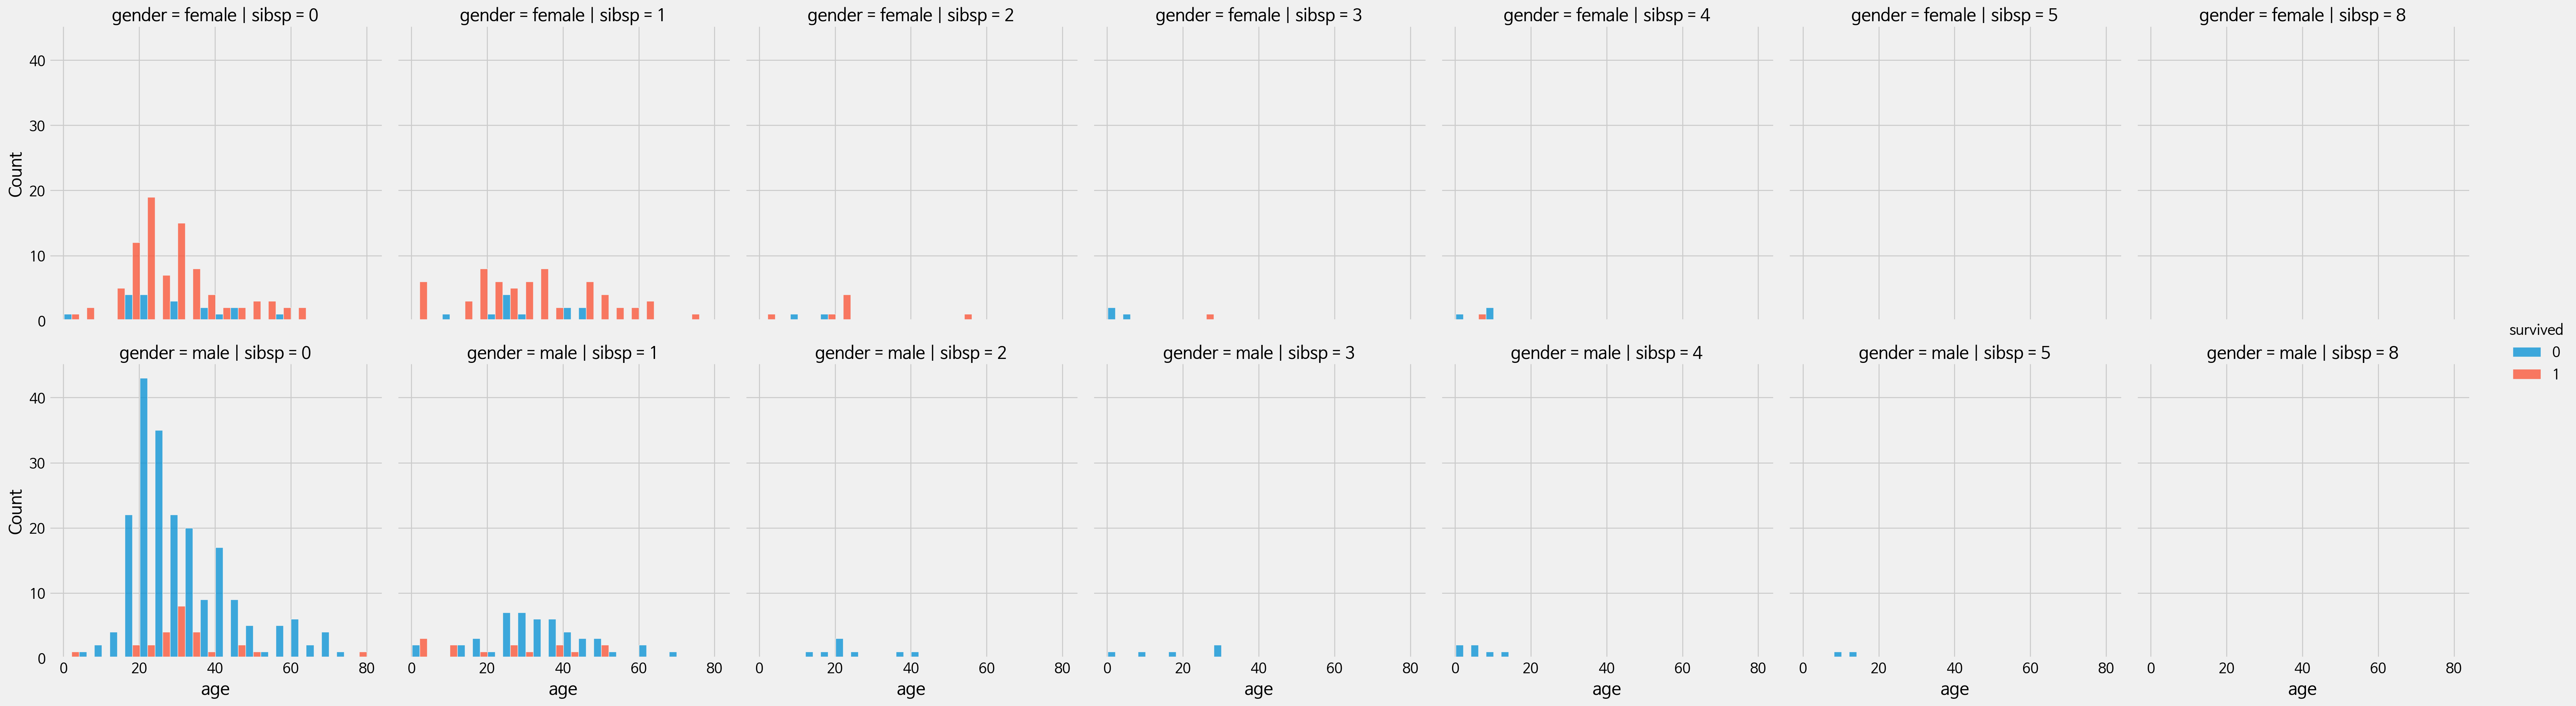

In [34]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

add gender_sibsp

In [35]:
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass
  return result

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"{train['gender_sibsp'].nunique()} / \n {train['gender_sibsp'].unique()} \n")
train.shape, test.shape, ori_te.shape

6 / 
 ['female_0' 'male_0' 'female_2' 'male_1' 'female_1' 'male_2'] 



((641, 14), (275, 14), (393, 13))

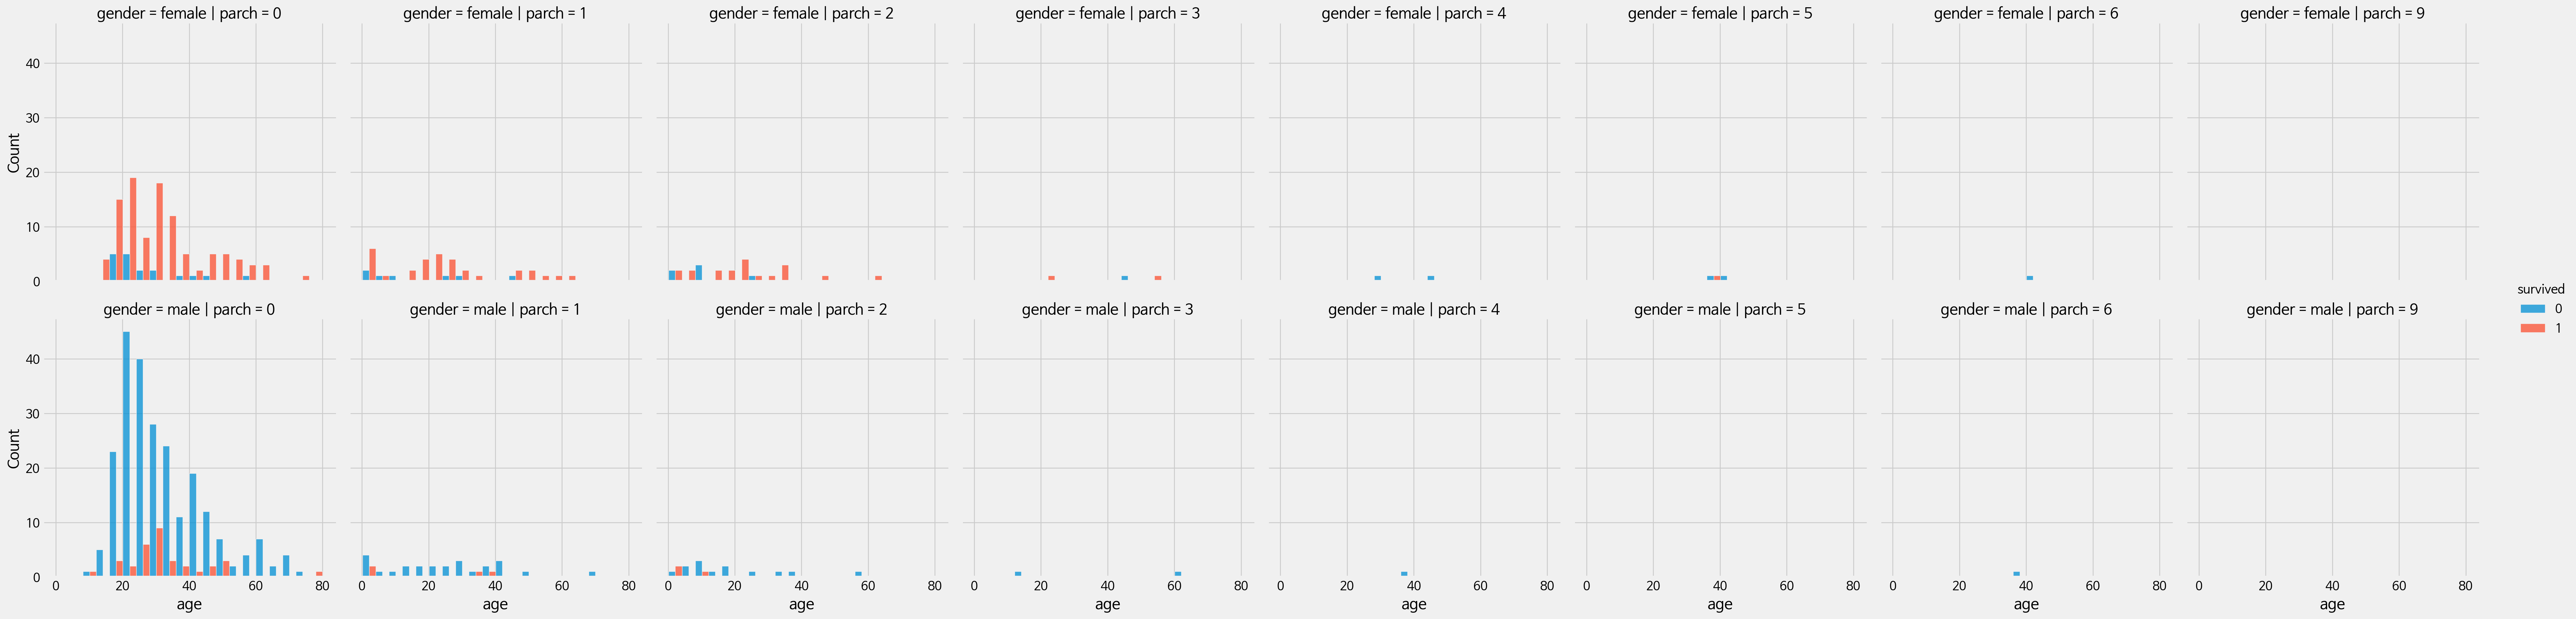

In [36]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

add gender_parch

In [37]:
train['parch'].unique()

array([0, 3, 2, 1, 5, 9, 4, 6])

In [38]:
train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"{train['gender_parch'].nunique()} / \n {train['gender_parch'].unique()} \n")
train.shape, test.shape, ori_te.shape

4 / 
 ['female_0' 'male_0' 'female_1' 'male_1'] 



((641, 15), (275, 15), (393, 14))

fare

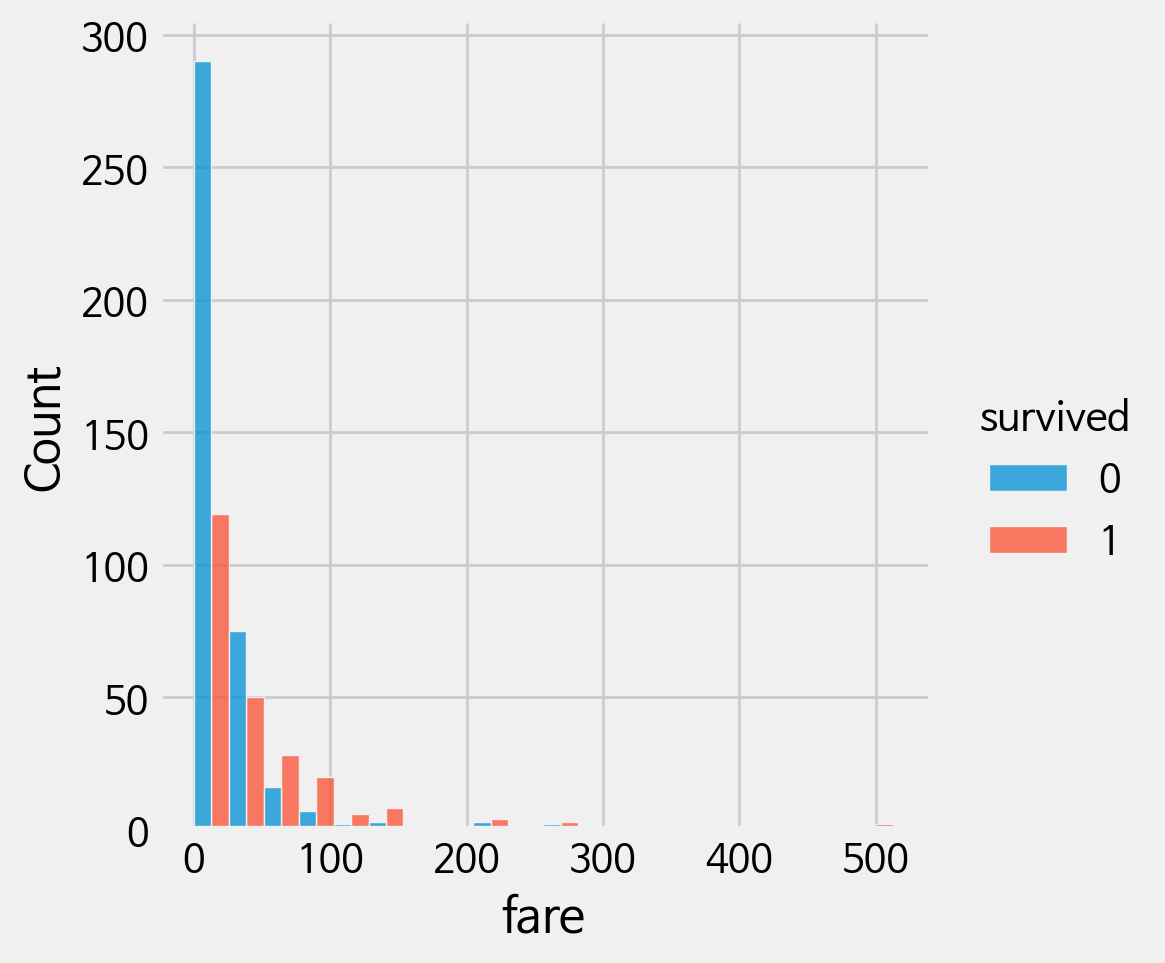

In [39]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

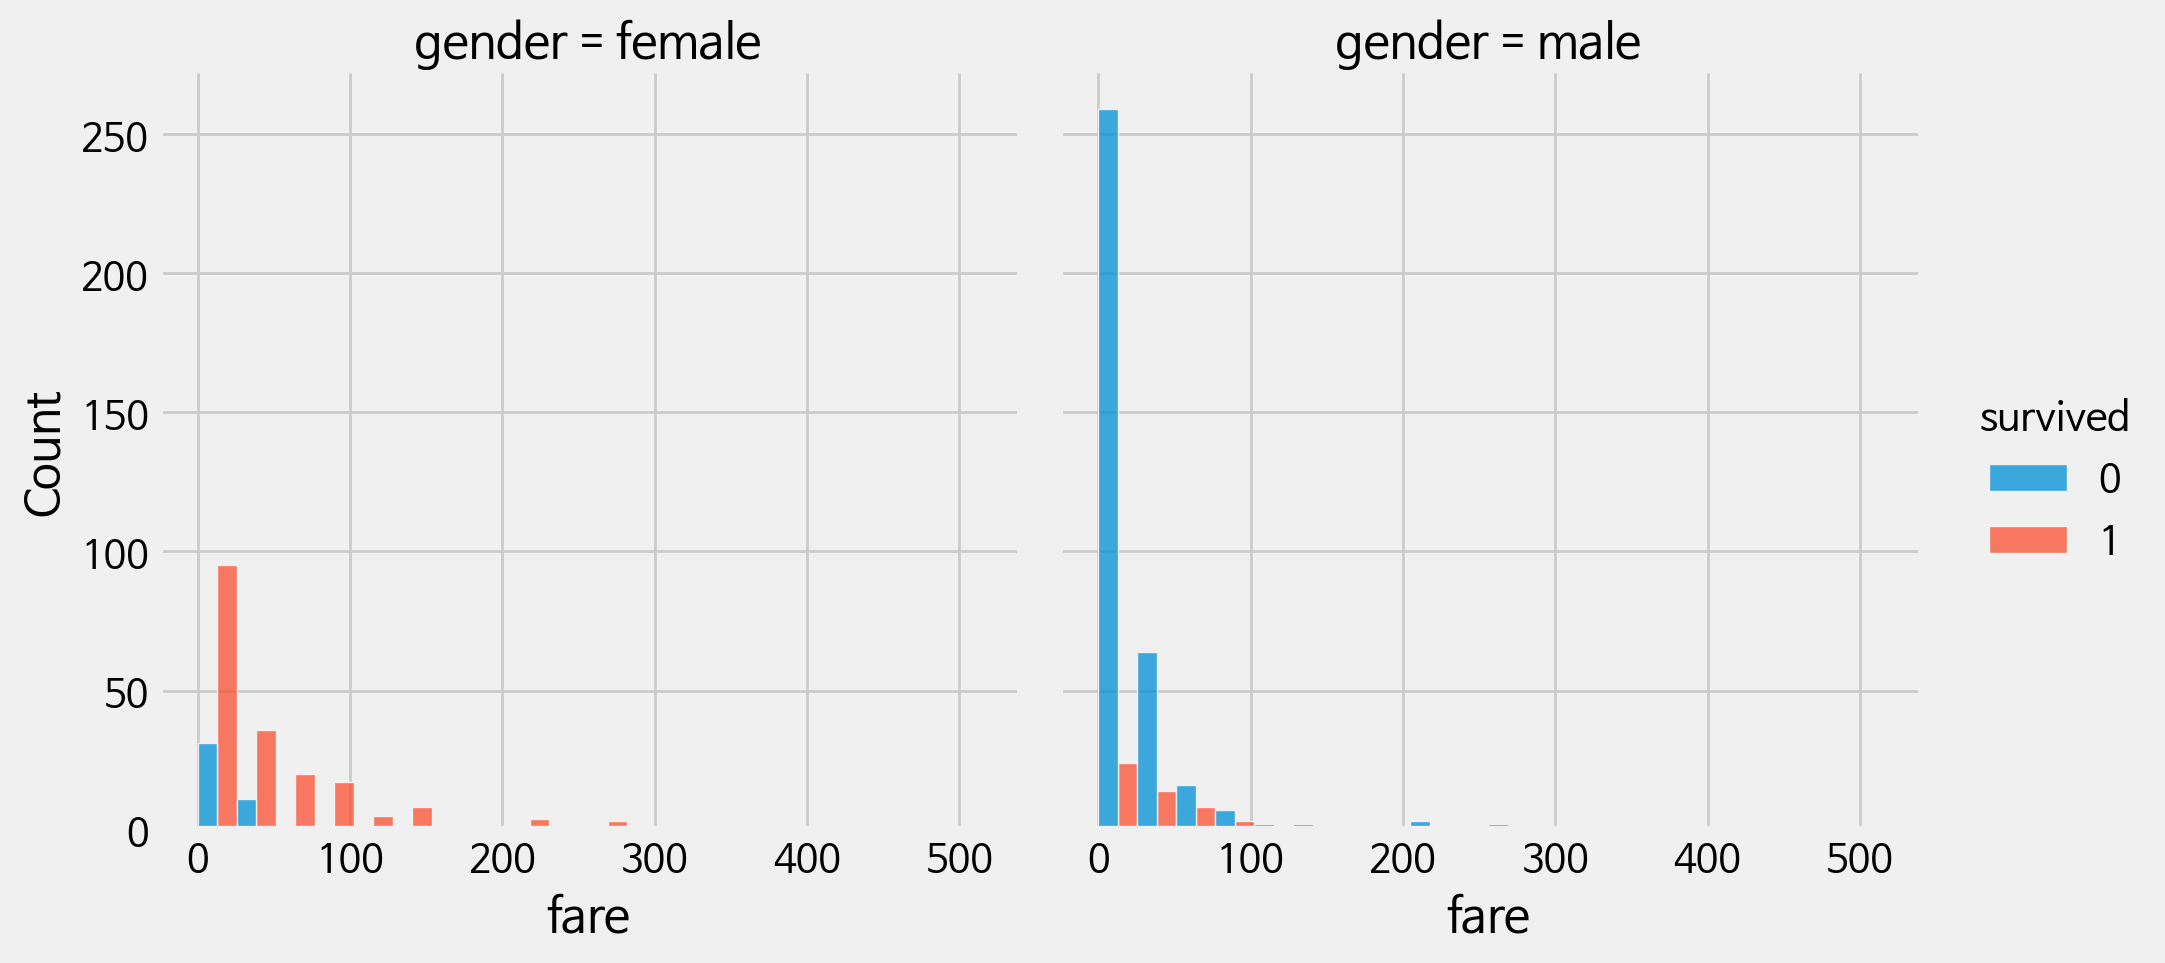

In [40]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

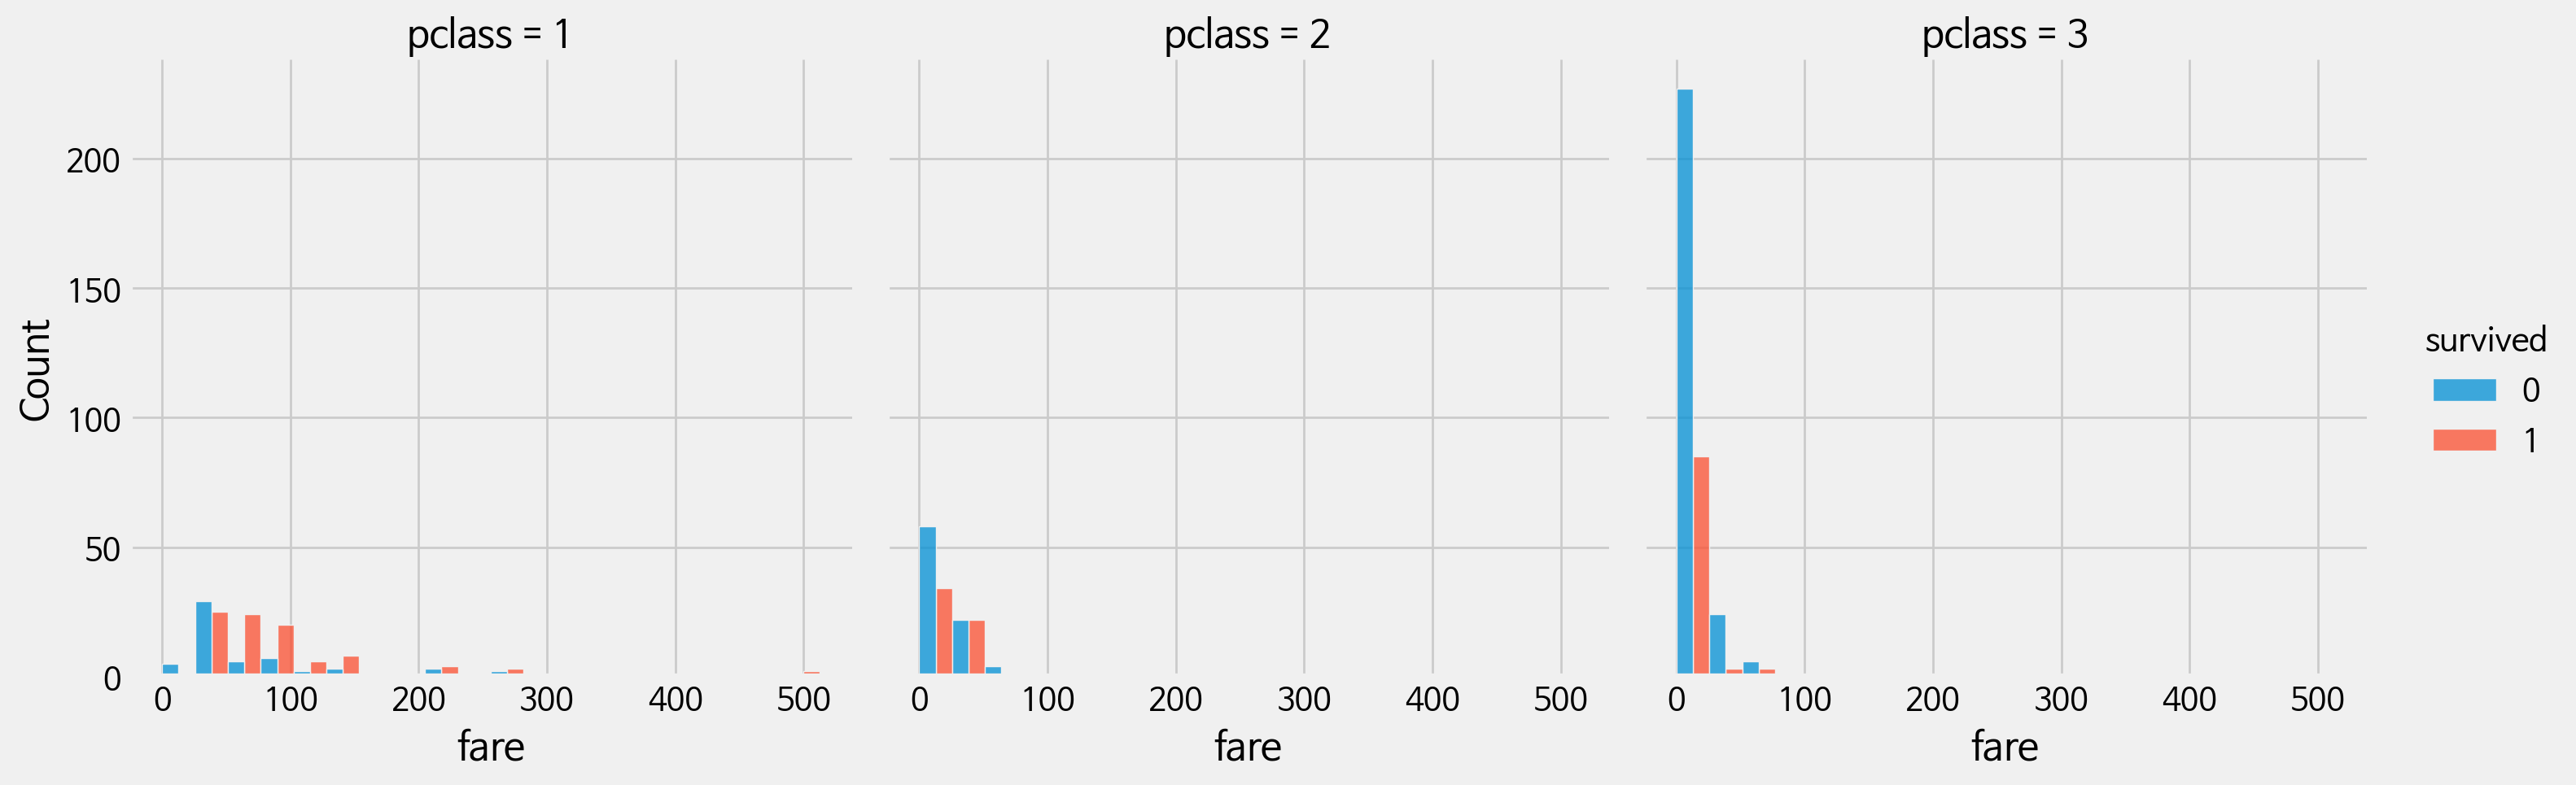

In [41]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

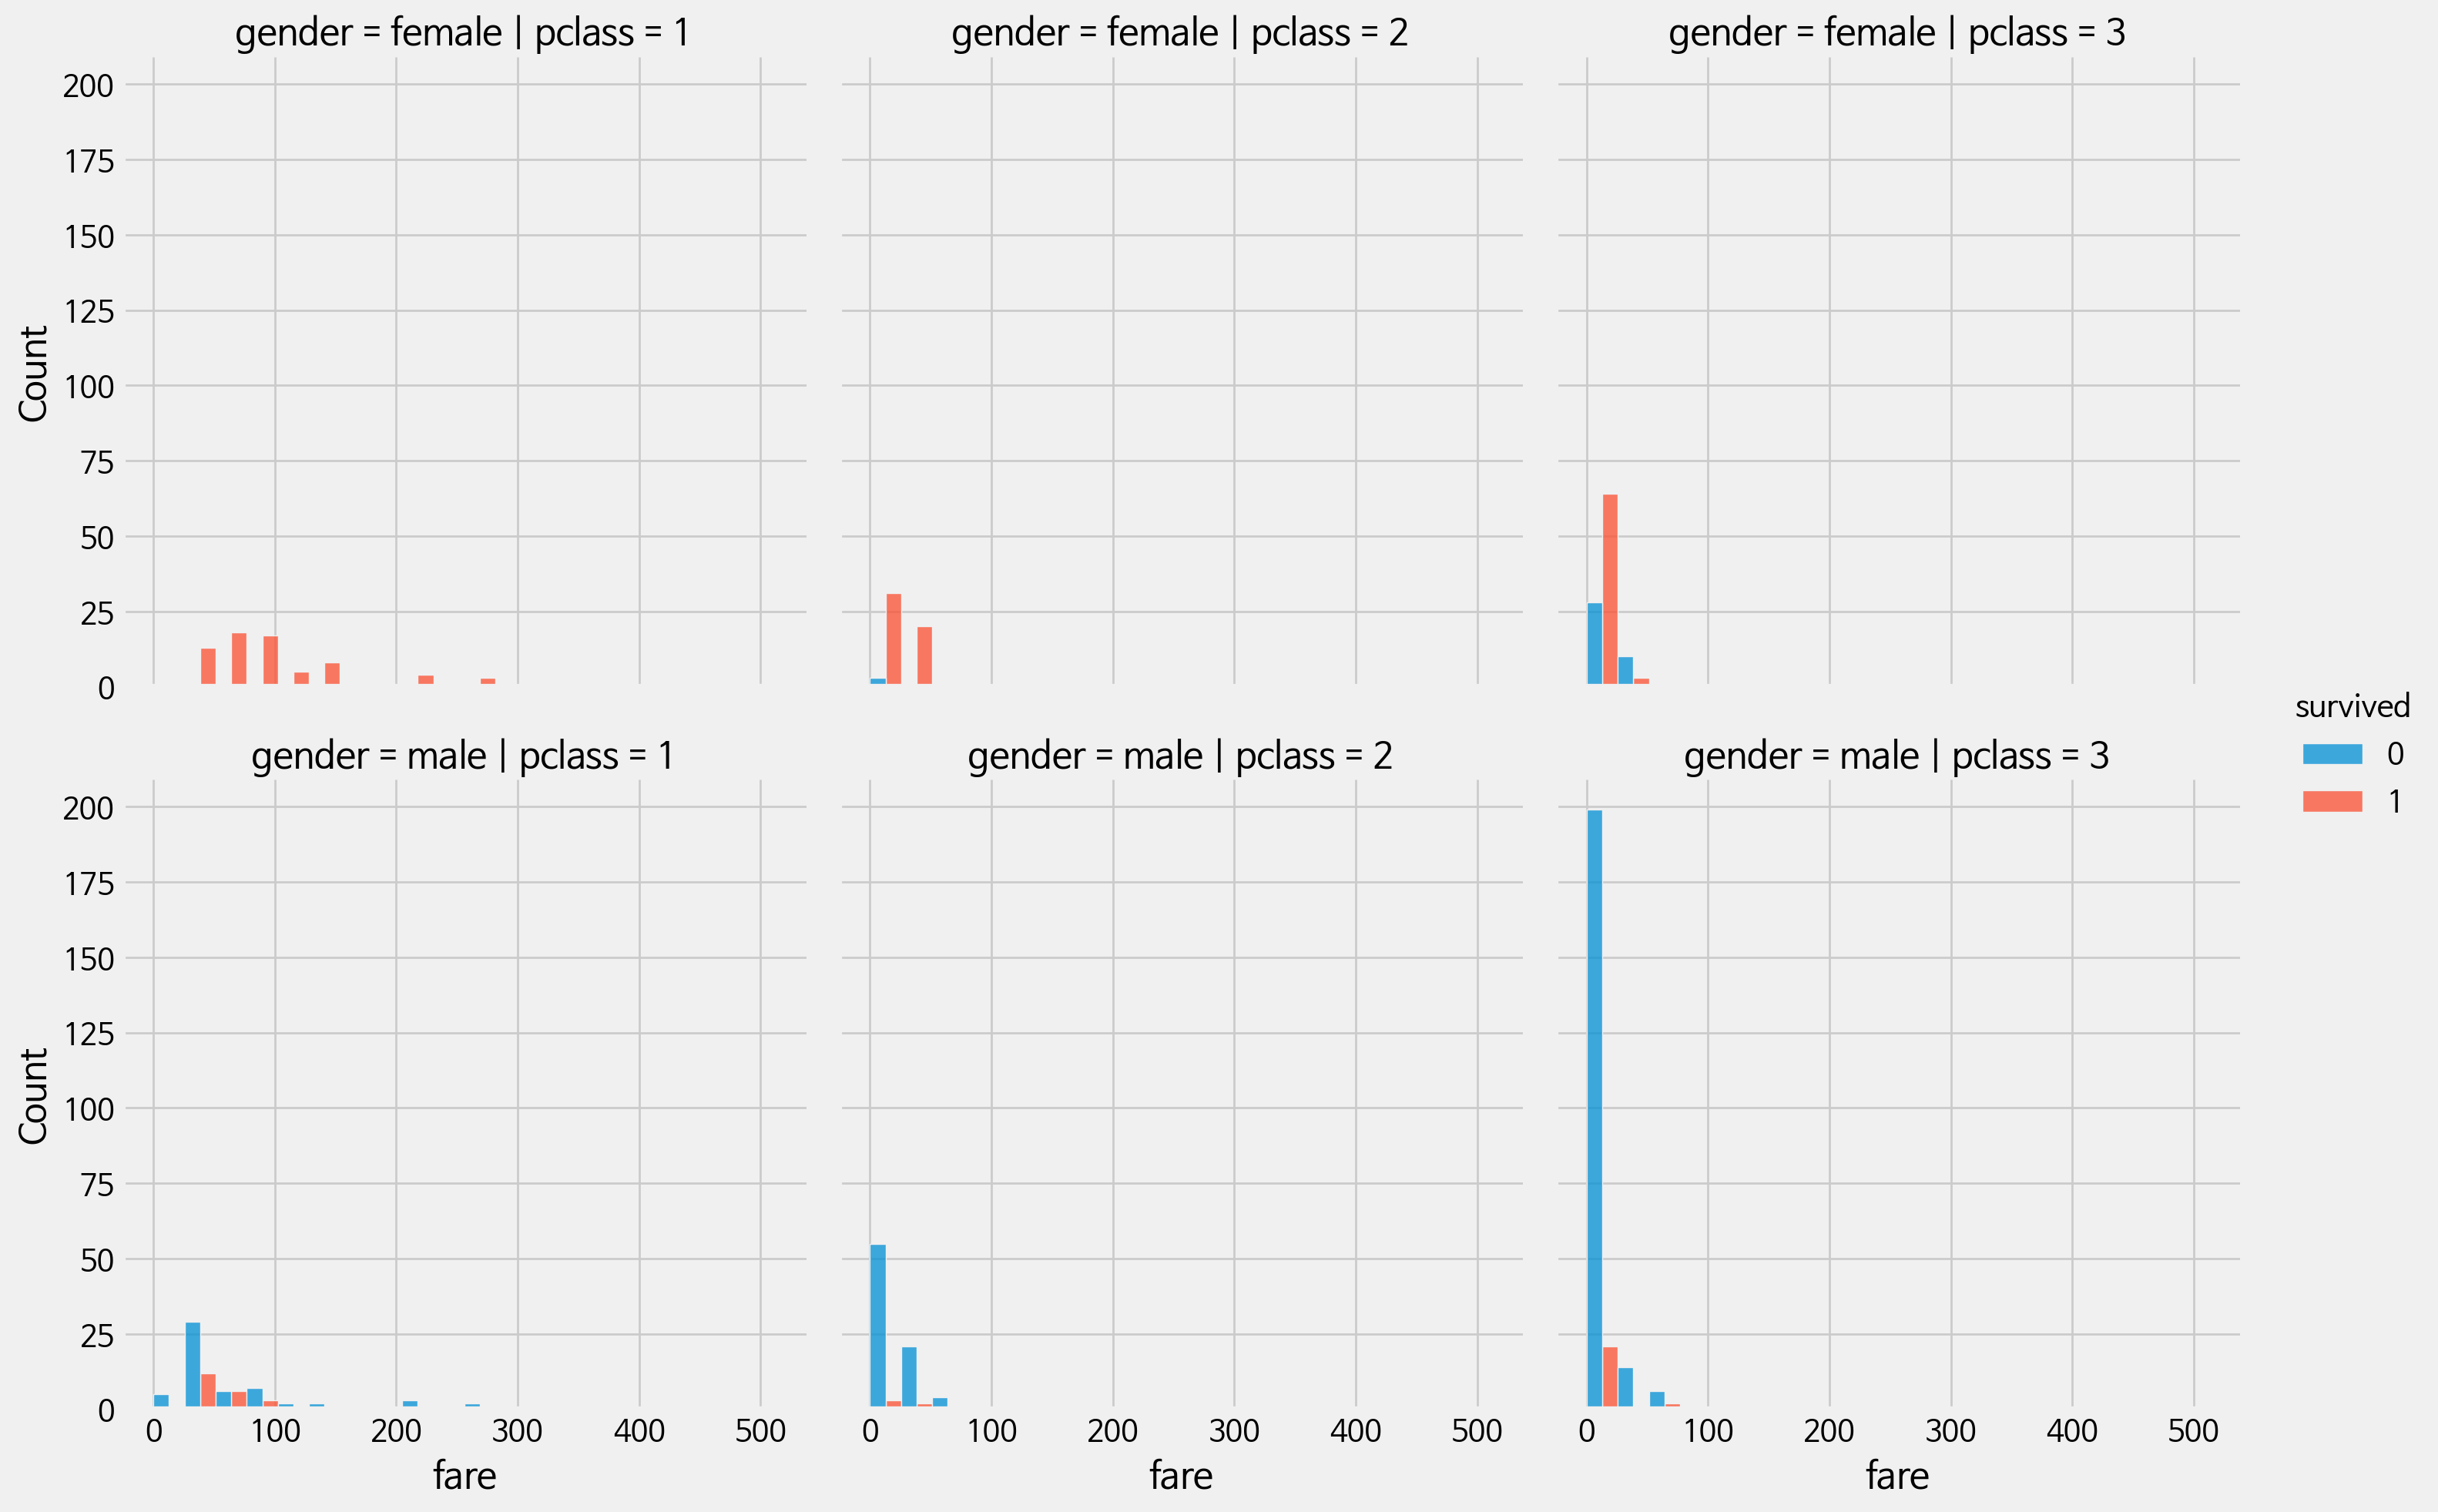

In [42]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [43]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch'],
      dtype='object')

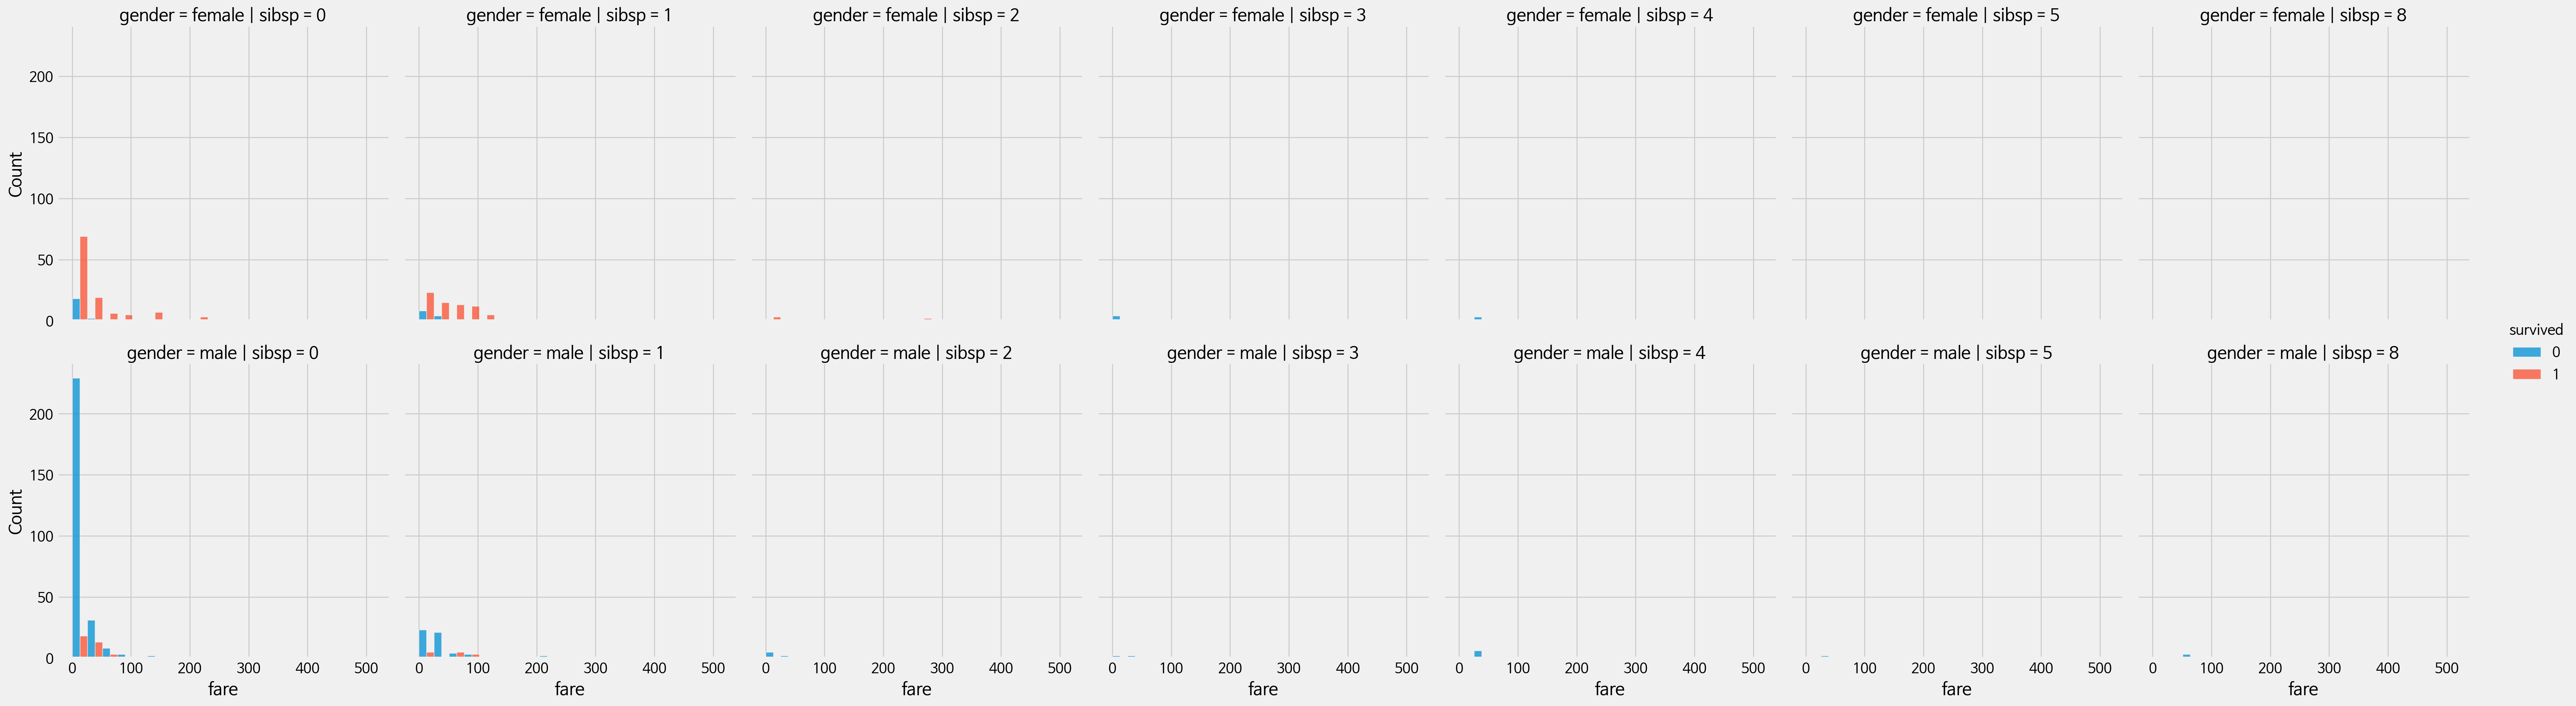

In [44]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

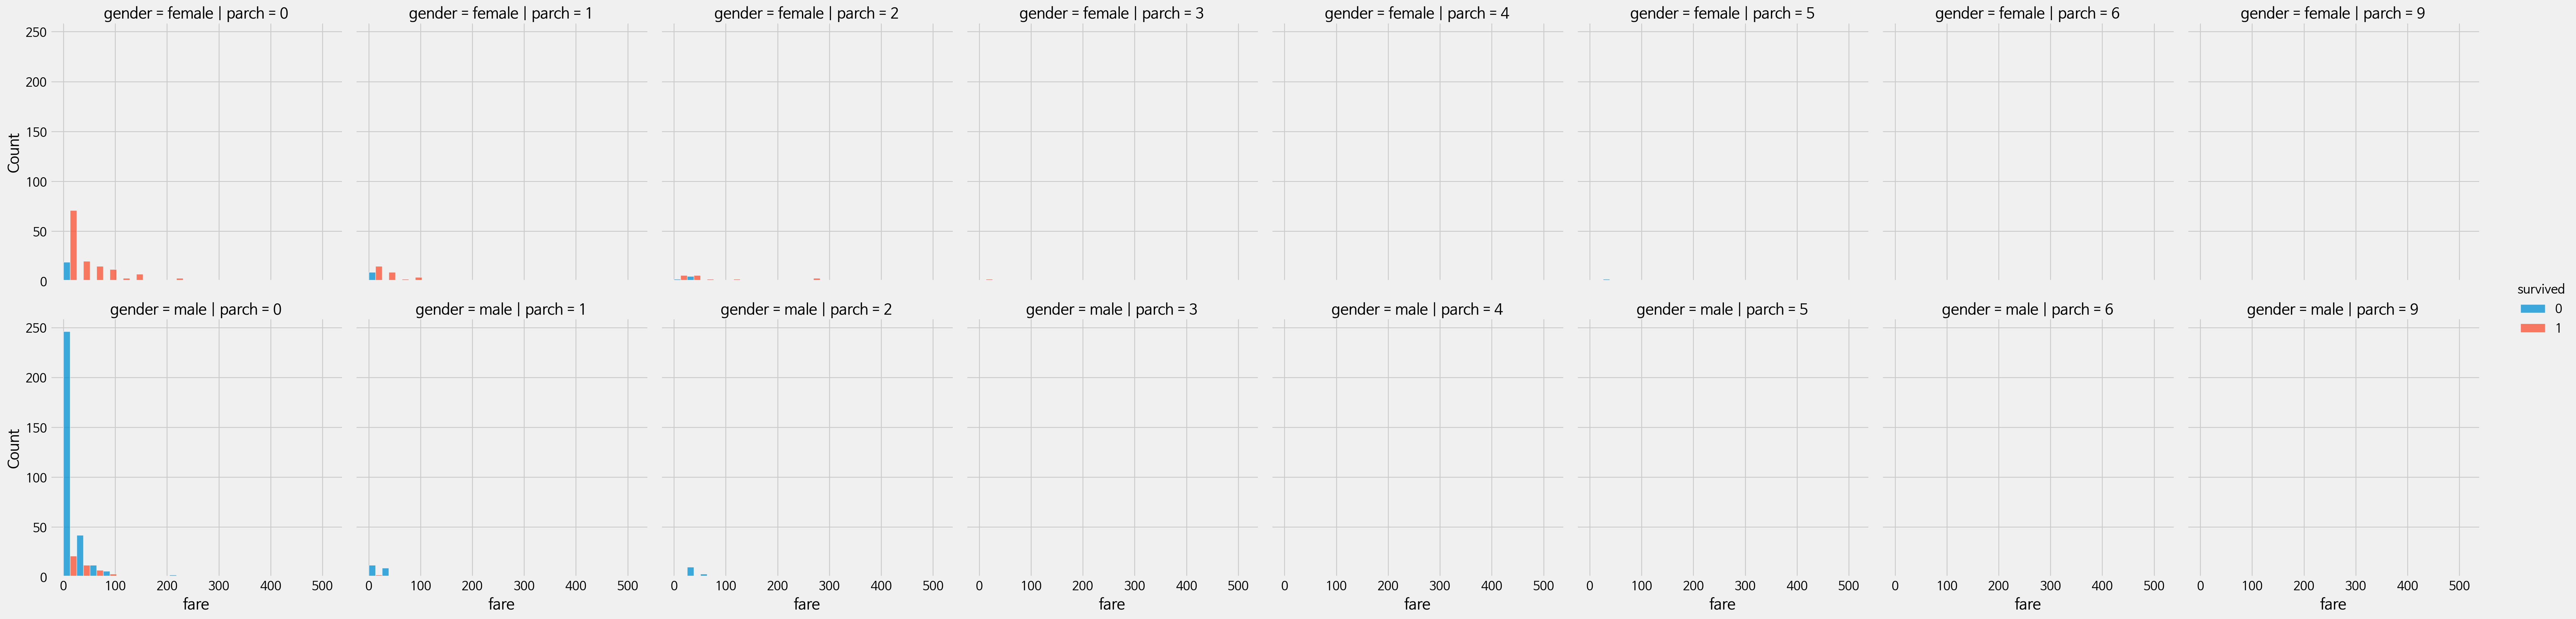

In [45]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

### ordinal features

In [46]:
ordinal_cols = ['pclass', 'sibsp', 'parch'] + ['survived']

train[ordinal_cols].describe()

,pclass,sibsp,parch,survived
count,641.000000,641.000000,641.000000,641.000000
mean,2.305772,0.466459,0.368175,0.377535
std,0.829221,0.961386,0.897140,0.485149
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000,0.000000
75%,3.000000,1.000000,0.000000,1.000000
max,3.000000,8.000000,9.000000,1.000000


In [47]:
train[ordinal_cols].corr()

,pclass,sibsp,parch,survived
pclass,1.000000,0.036405,0.039566,-0.299053
sibsp,0.036405,1.000000,0.367602,-0.013008
parch,0.039566,0.367602,1.000000,0.067856
survived,-0.299053,-0.013008,0.067856,1.000000


add reversed_pclass

In [48]:
train['reversed_pclass'] = train['pclass'].map(lambda x: 4 - int(x))
test['reversed_pclass'] = test['pclass'].map(lambda x: 4 - int(x))
ori_te['reversed_pclass'] = ori_te['pclass'].map(lambda x: 4 - int(x))

train[ordinal_cols+['reversed_pclass']].corr()

,pclass,sibsp,parch,survived,reversed_pclass
pclass,1.000000,0.036405,0.039566,-0.299053,-1.000000
sibsp,0.036405,1.000000,0.367602,-0.013008,-0.036405
parch,0.039566,0.367602,1.000000,0.067856,-0.039566
survived,-0.299053,-0.013008,0.067856,1.000000,0.299053
reversed_pclass,-1.000000,-0.036405,-0.039566,0.299053,1.000000


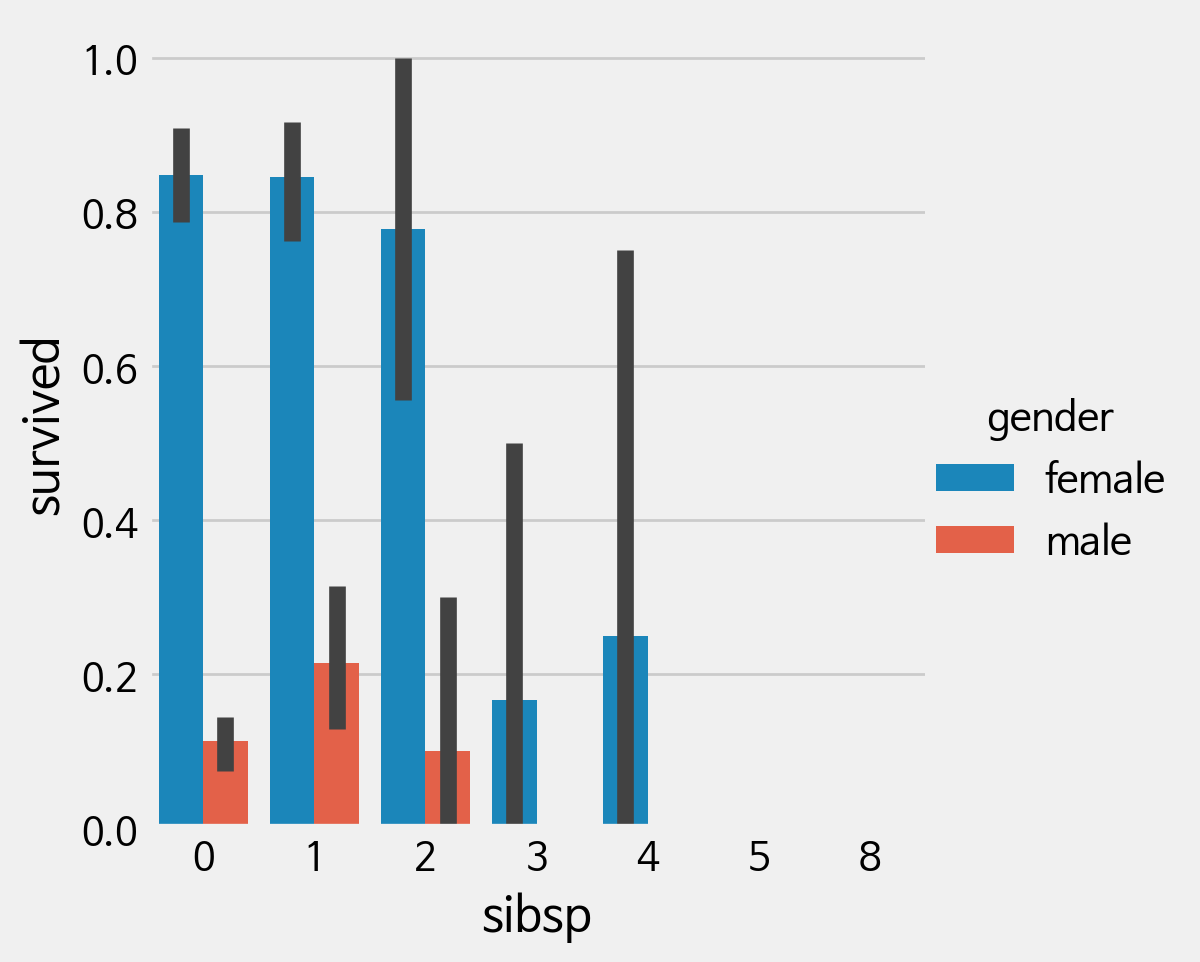

In [49]:
sns.catplot(data=train, x="sibsp", y="survived", hue="gender", kind="bar")

In [50]:
c1 = train['sibsp'] == 8
c2 = train['gender'] == 'female'
c = c1 & c2
train.loc[c]['survived'].mean()

nan

In [51]:
c1 = train['sibsp'] >= 2
c2 = train['gender'] == 'male'
c = c1 & c2
train.loc[c]['survived'].mean()

0.038461538461538464

add sibsp_male

In [52]:
for df in [train, test, ori_te]:
  c1 = df['sibsp'] >= 2
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['sibsp_male'] = c

train.shape, test.shape, ori_te.shape

((641, 17), (275, 17), (393, 16))

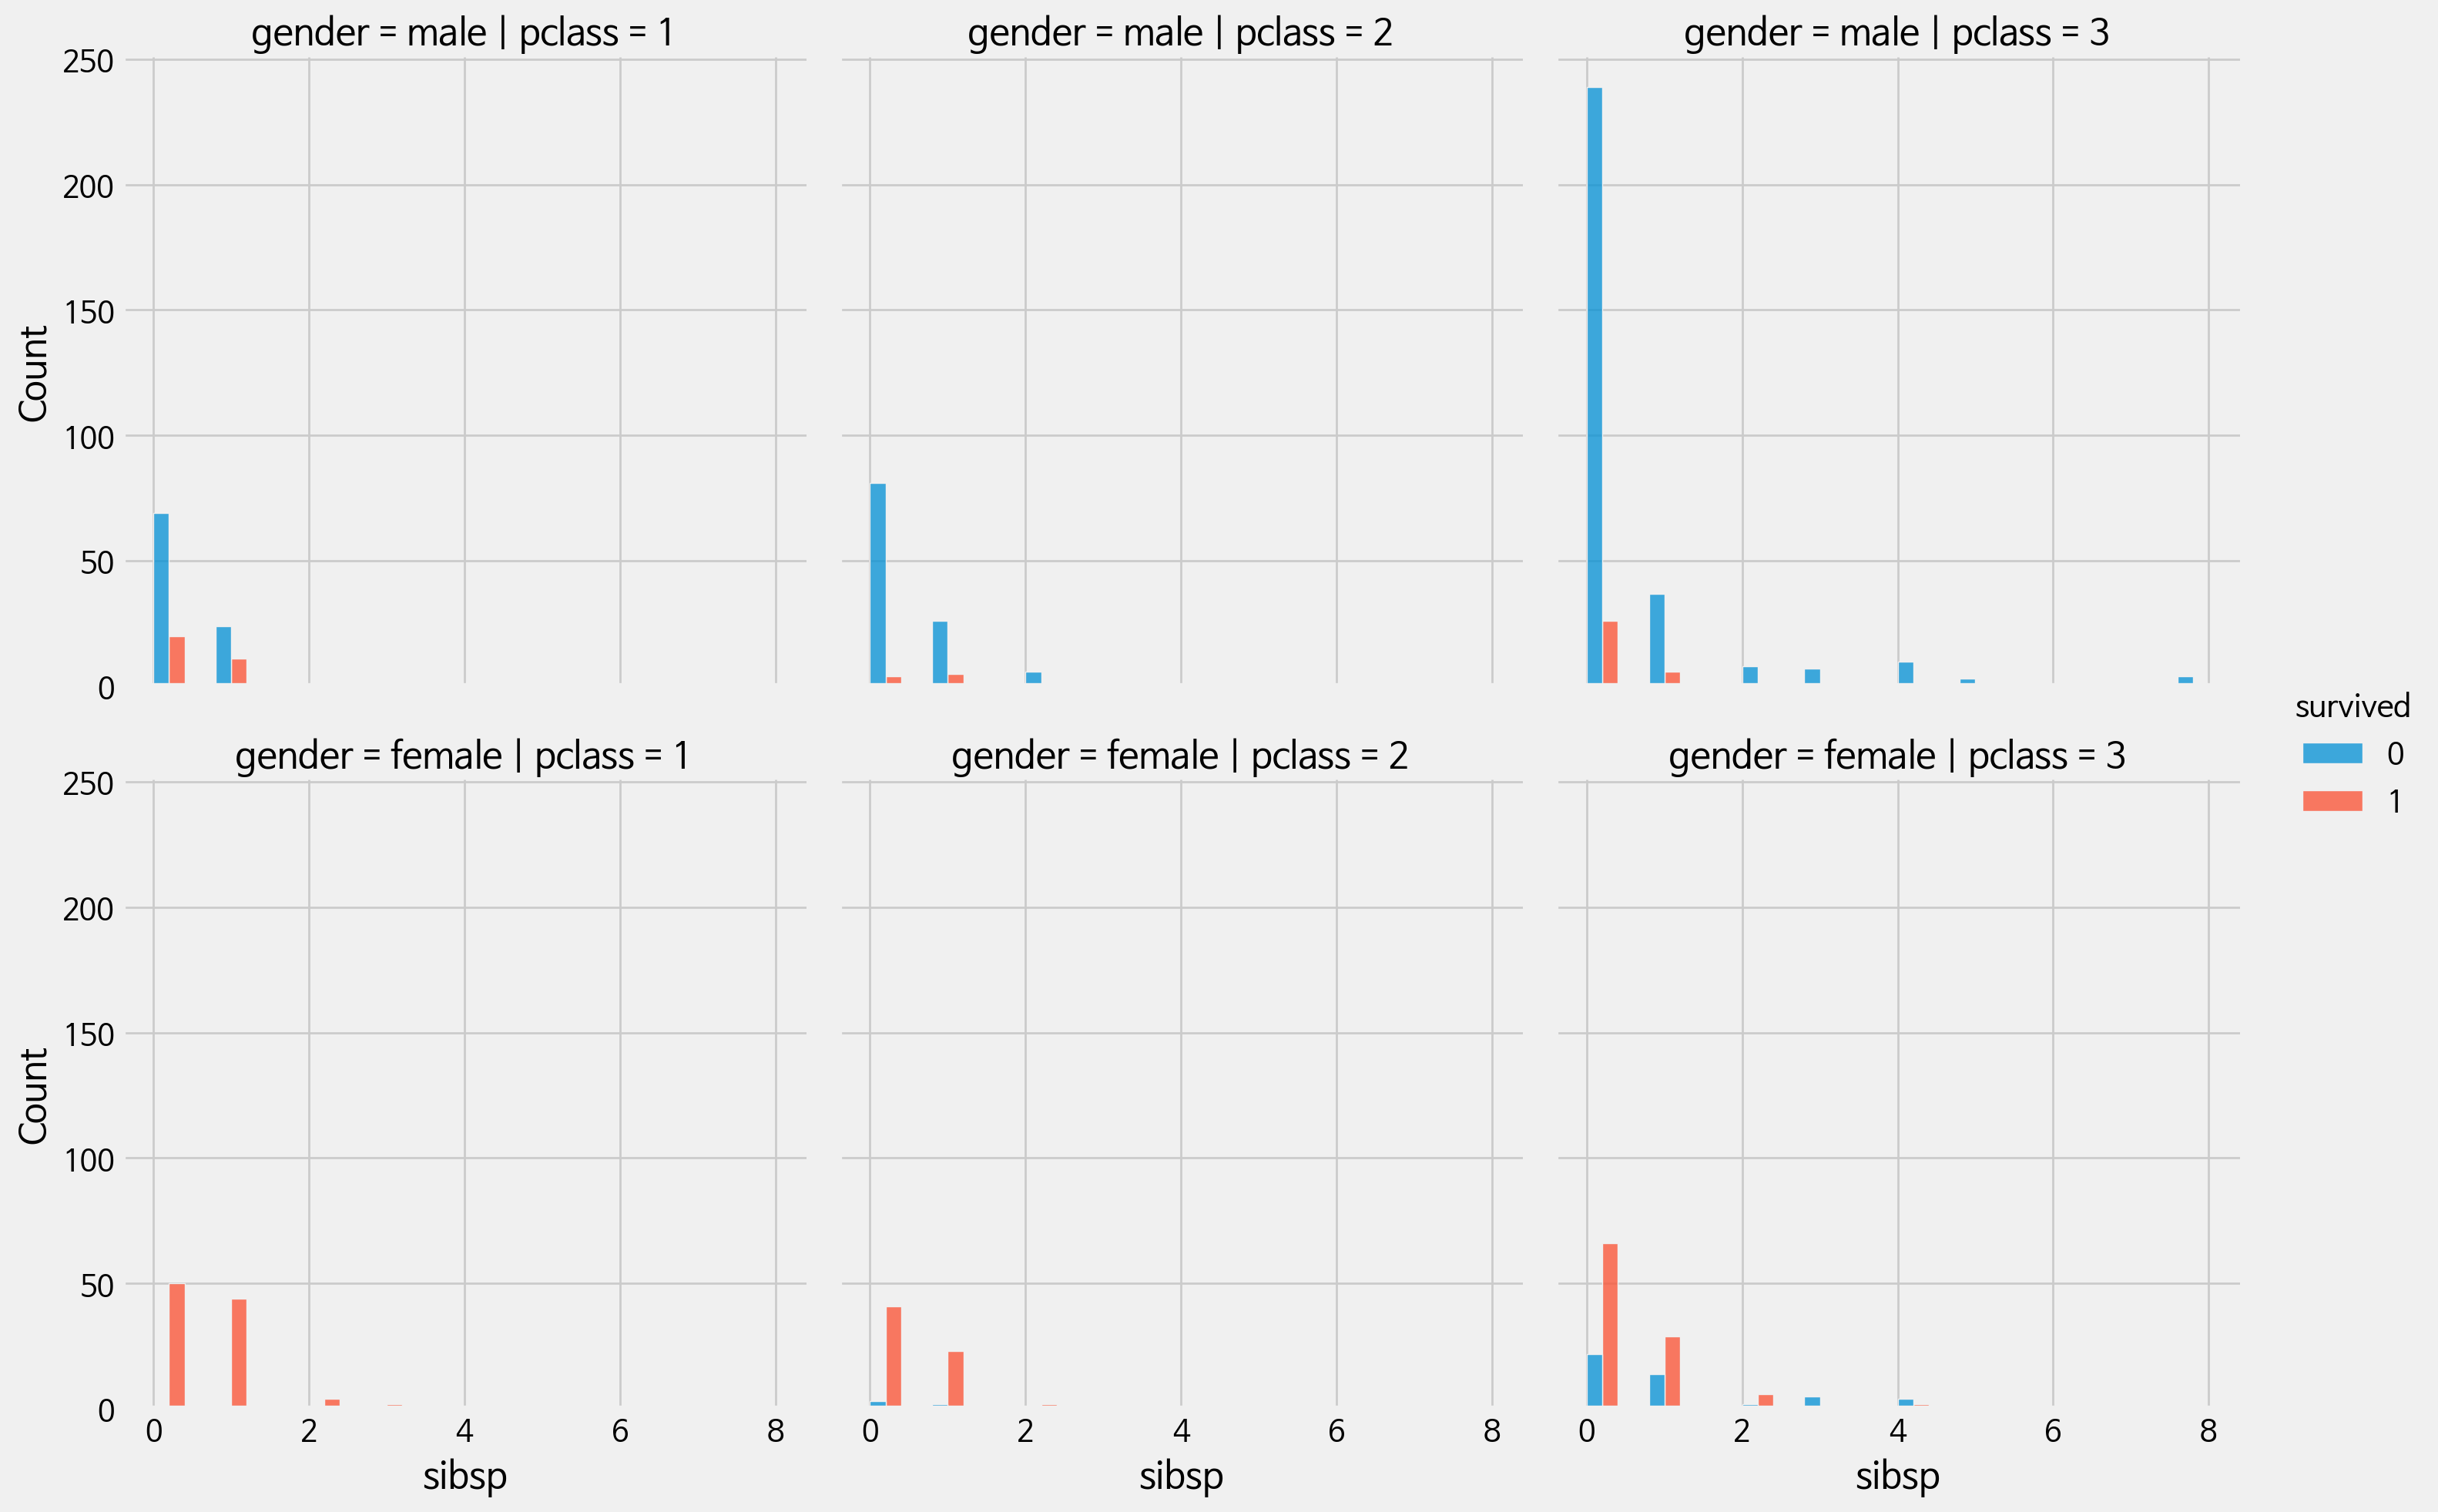

In [53]:
sns.displot(ori_tr, x="sibsp", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [54]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male'],
      dtype='object')

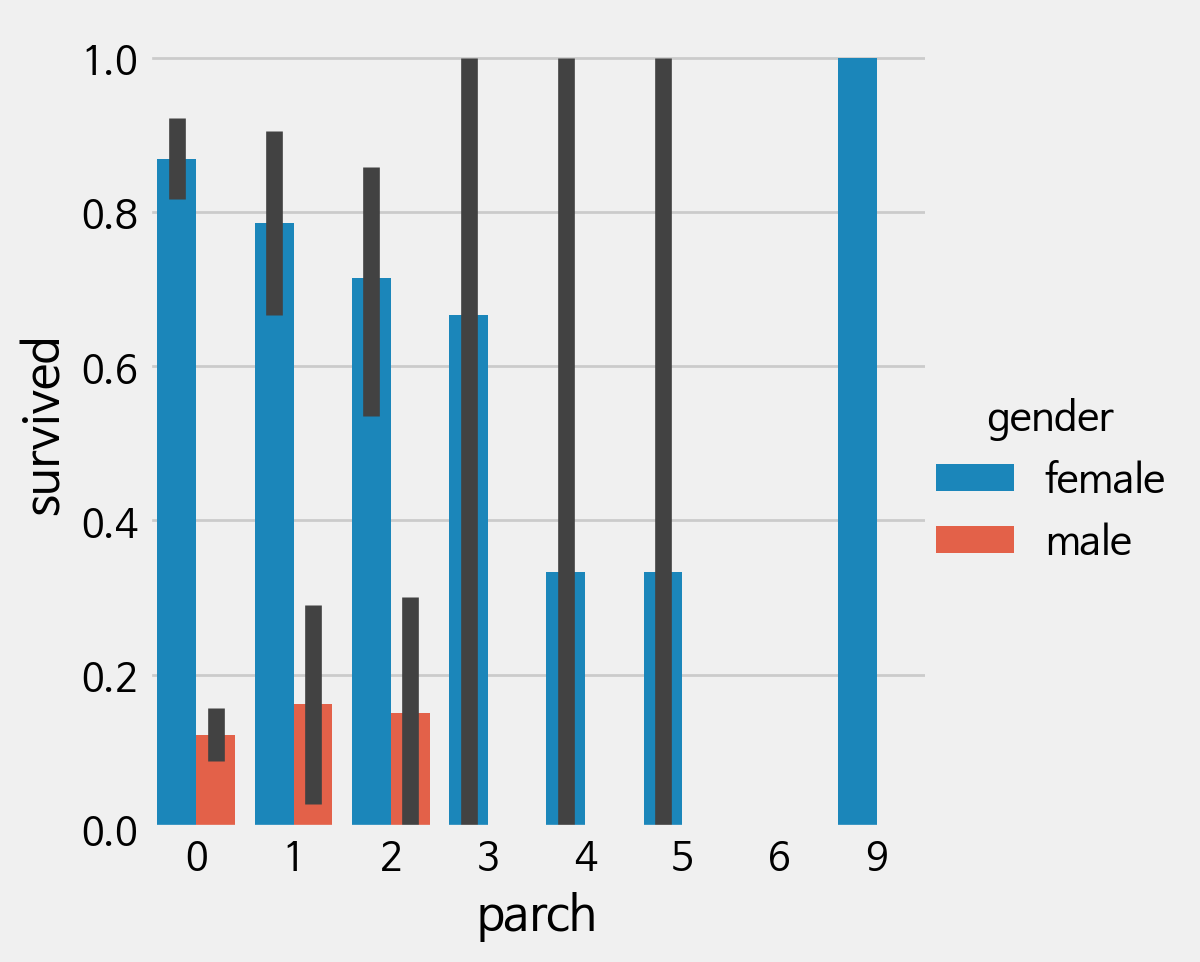

In [55]:
sns.catplot(data=train, x="parch", y="survived", hue="gender", kind="bar")

In [56]:
c1 = train['gender'] == 'male'
c2 = train['parch'] >= 3
c = c1 & c2
train.loc[c]['survived'].mean()

0.0

add parch_male

In [57]:
for df in [train, test, ori_te]:
  c1 = df['parch'] >= 3
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['parch_male'] = c

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

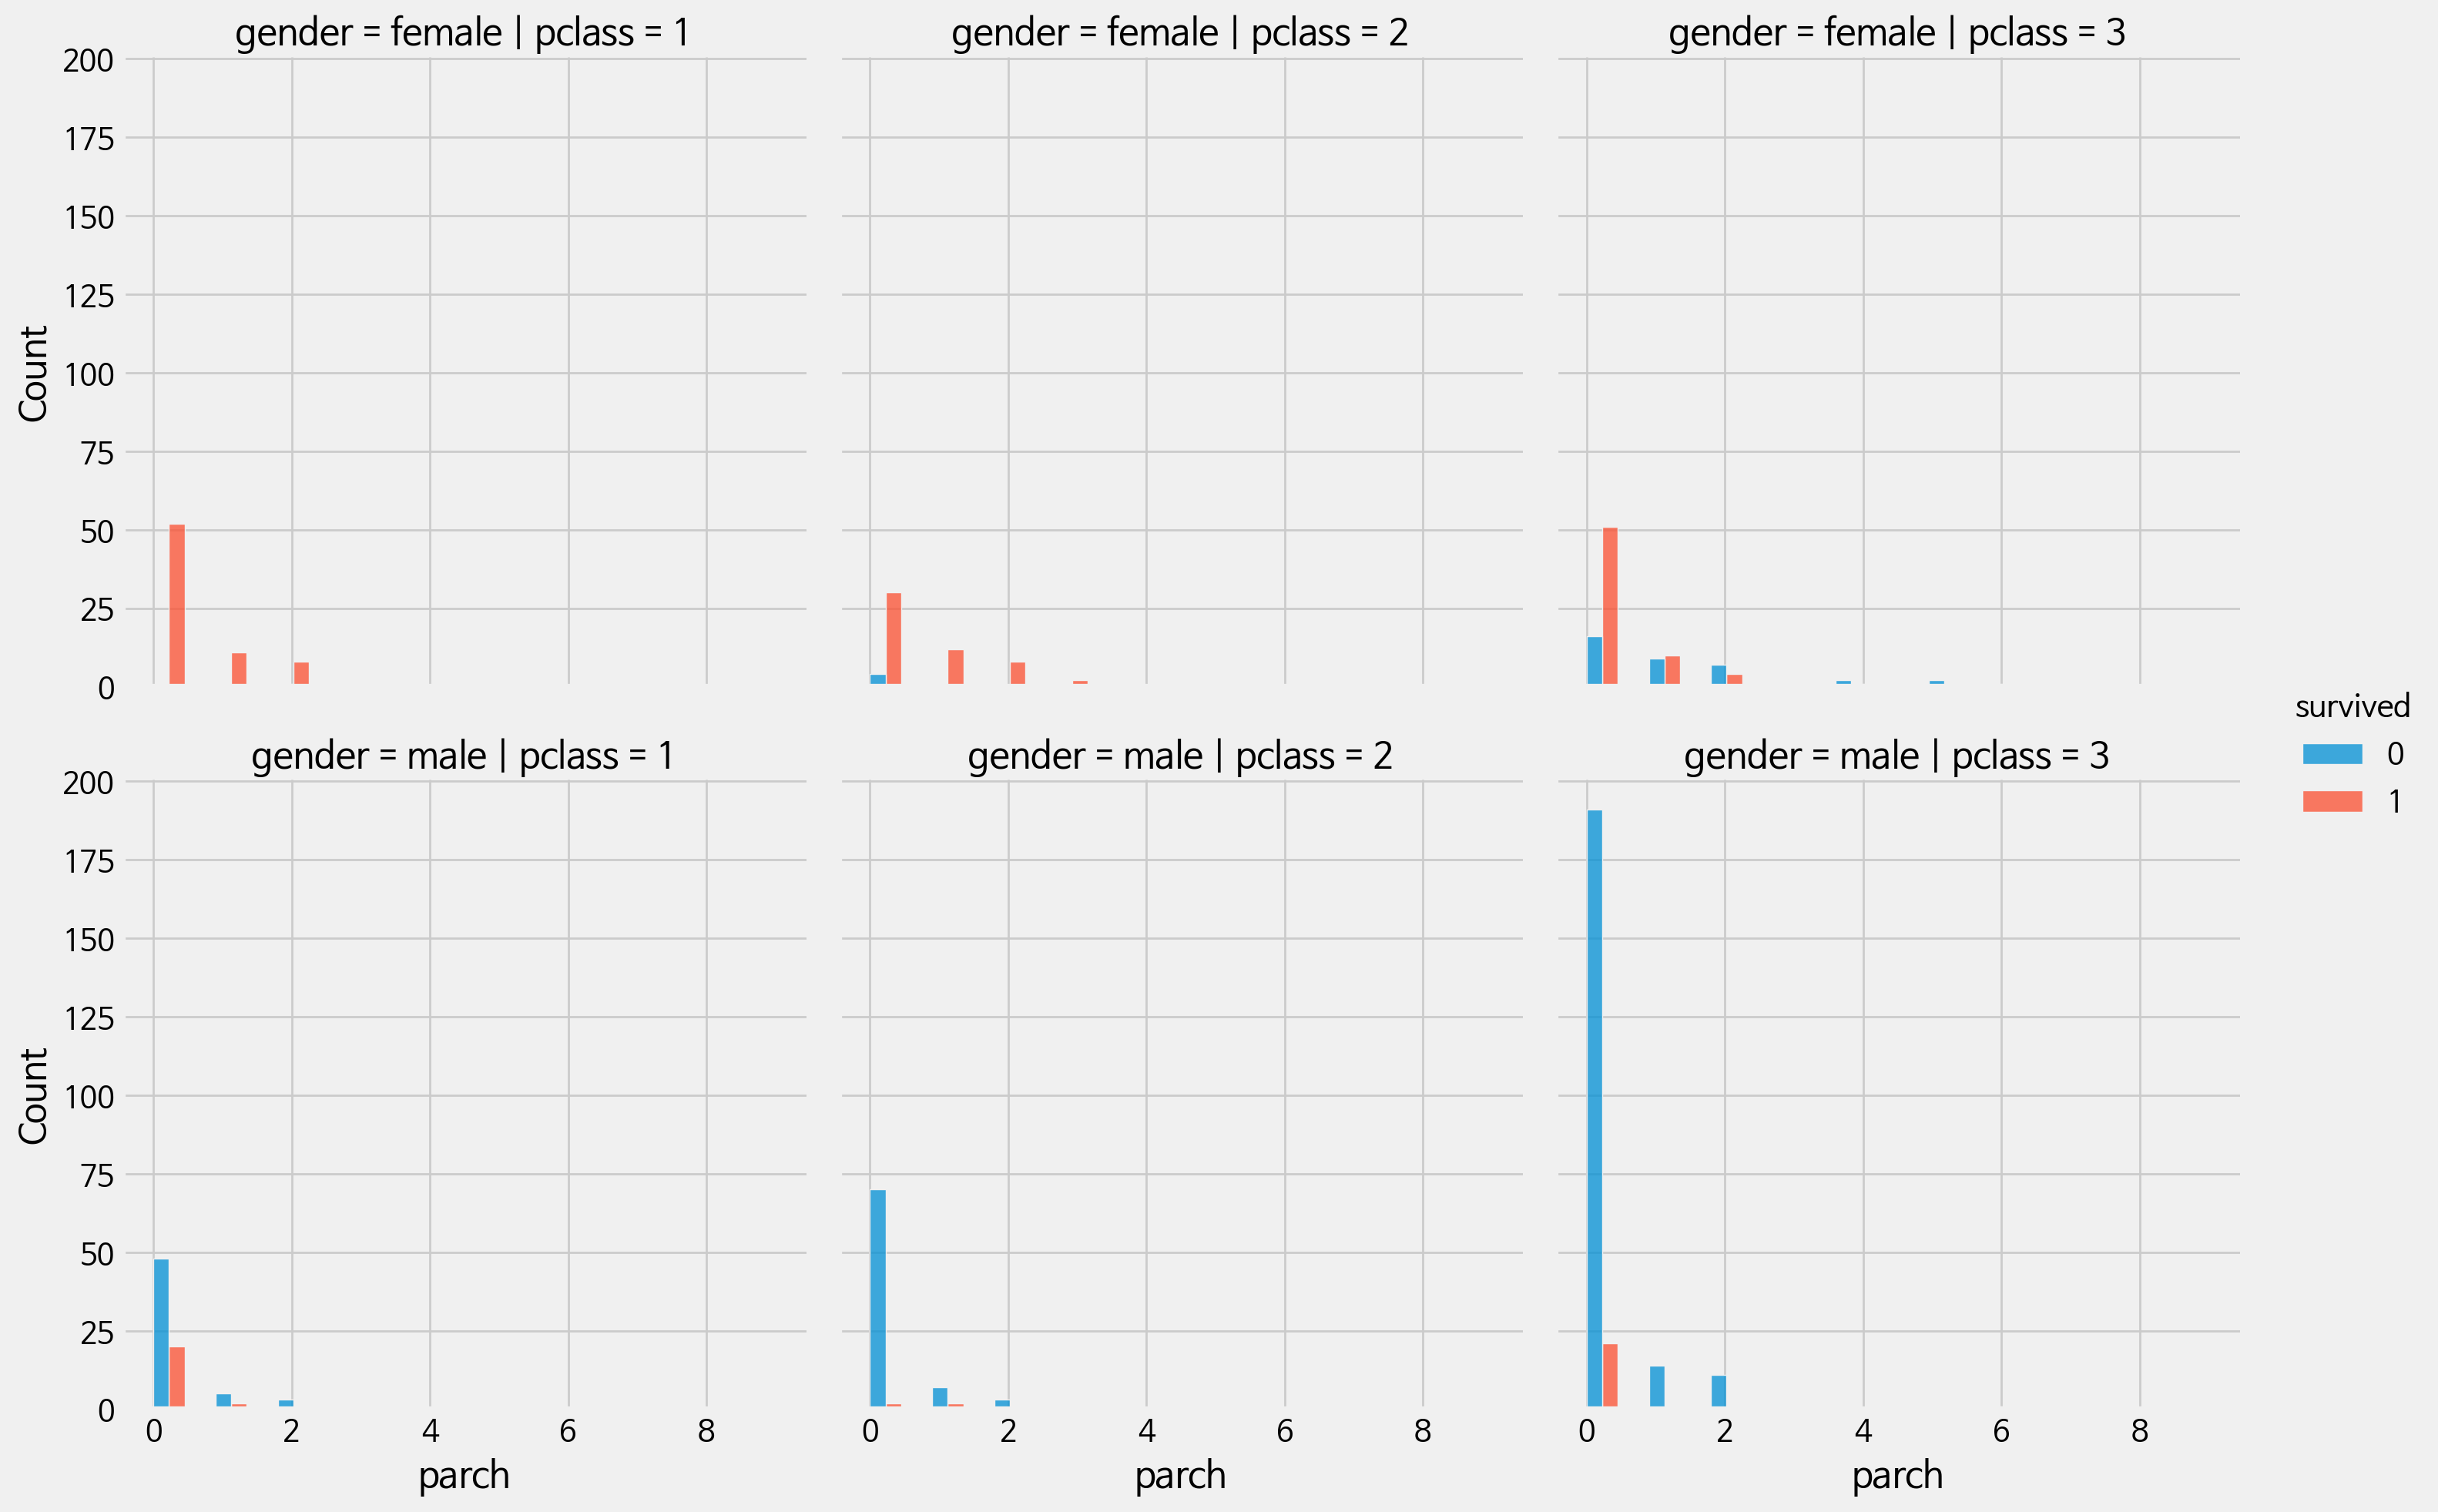

In [58]:
sns.displot(train, x="parch", hue="survived", multiple="dodge", bins=20, col="pclass", row="gender")

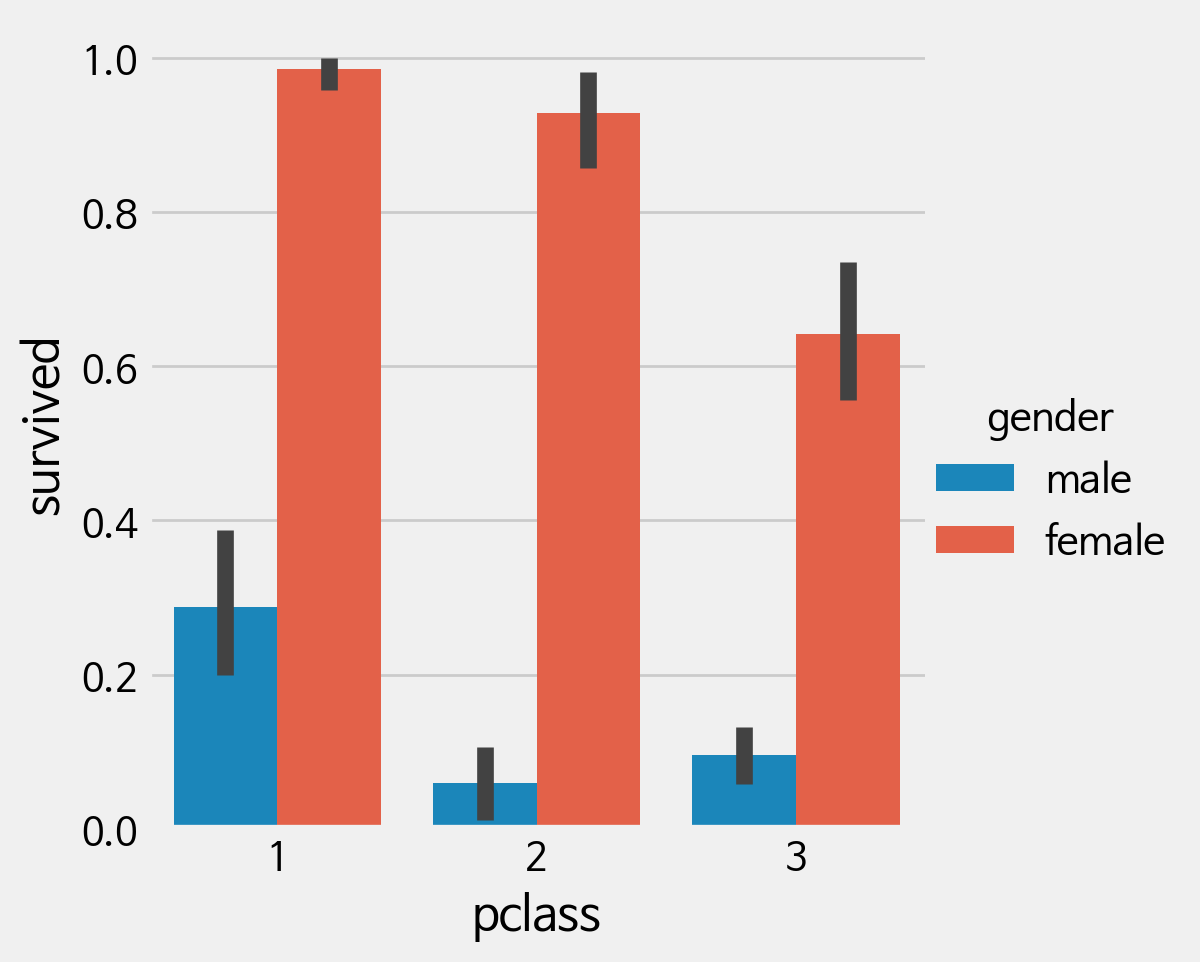

In [59]:
sns.catplot(data=train, x="pclass", y="survived", hue="gender", kind="bar")

### categorical features

In [60]:
train.columns

Index(['survived', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'embarked', 'infant', 'gender_infant',
       'gender_pclass', 'gender_sibsp', 'gender_parch', 'reversed_pclass',
       'sibsp_male', 'parch_male'],
      dtype='object')

In [61]:
categorical_cols = ['gender', 'embarked'] + ['survived']
train[categorical_cols].describe(include='all')

,gender,embarked,survived
count,641,641,641.000000
unique,2,3,NaN
top,male,S,NaN
freq,407,455,NaN
mean,NaN,NaN,0.377535
std,NaN,NaN,0.485149
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


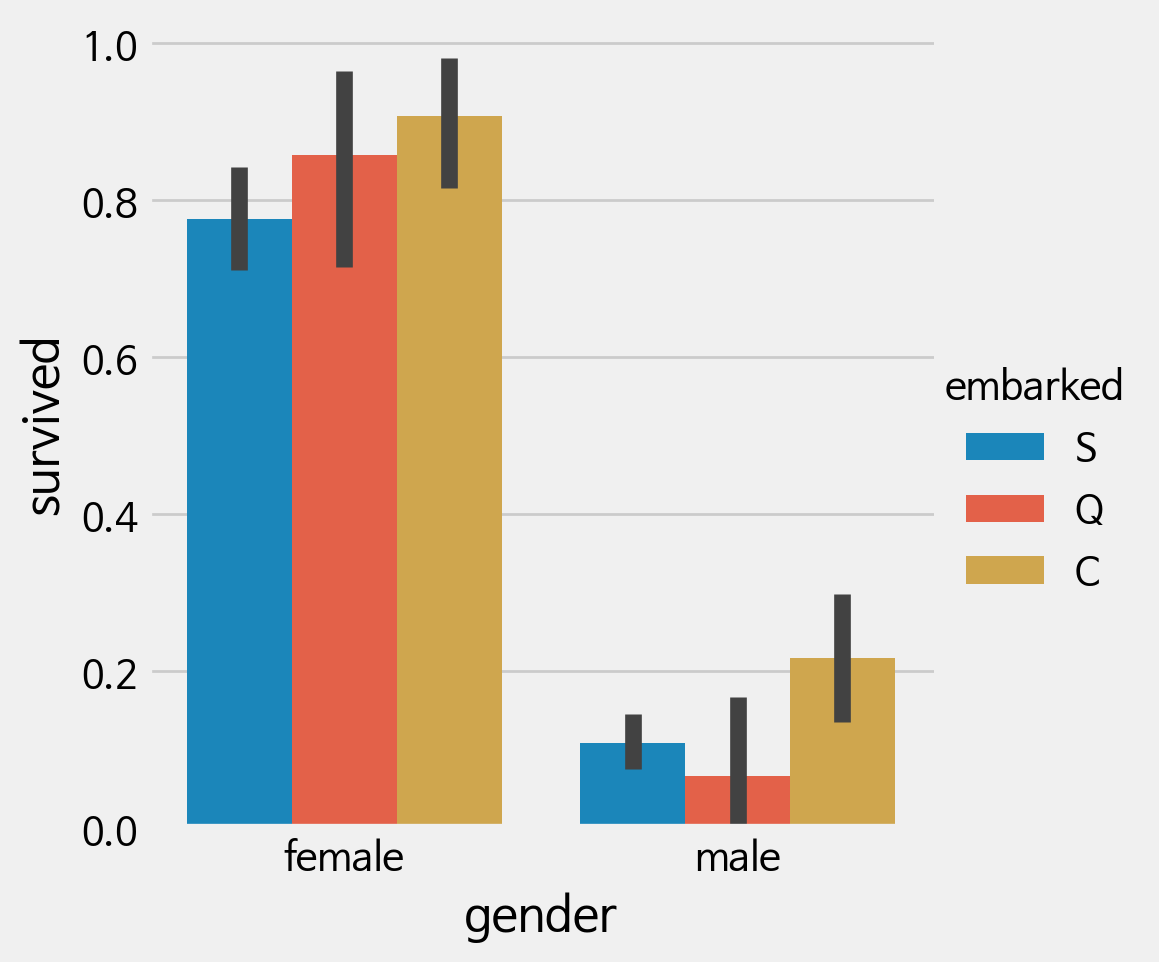

In [62]:
sns.catplot(data=train, x="gender", y="survived", hue="embarked", kind="bar")

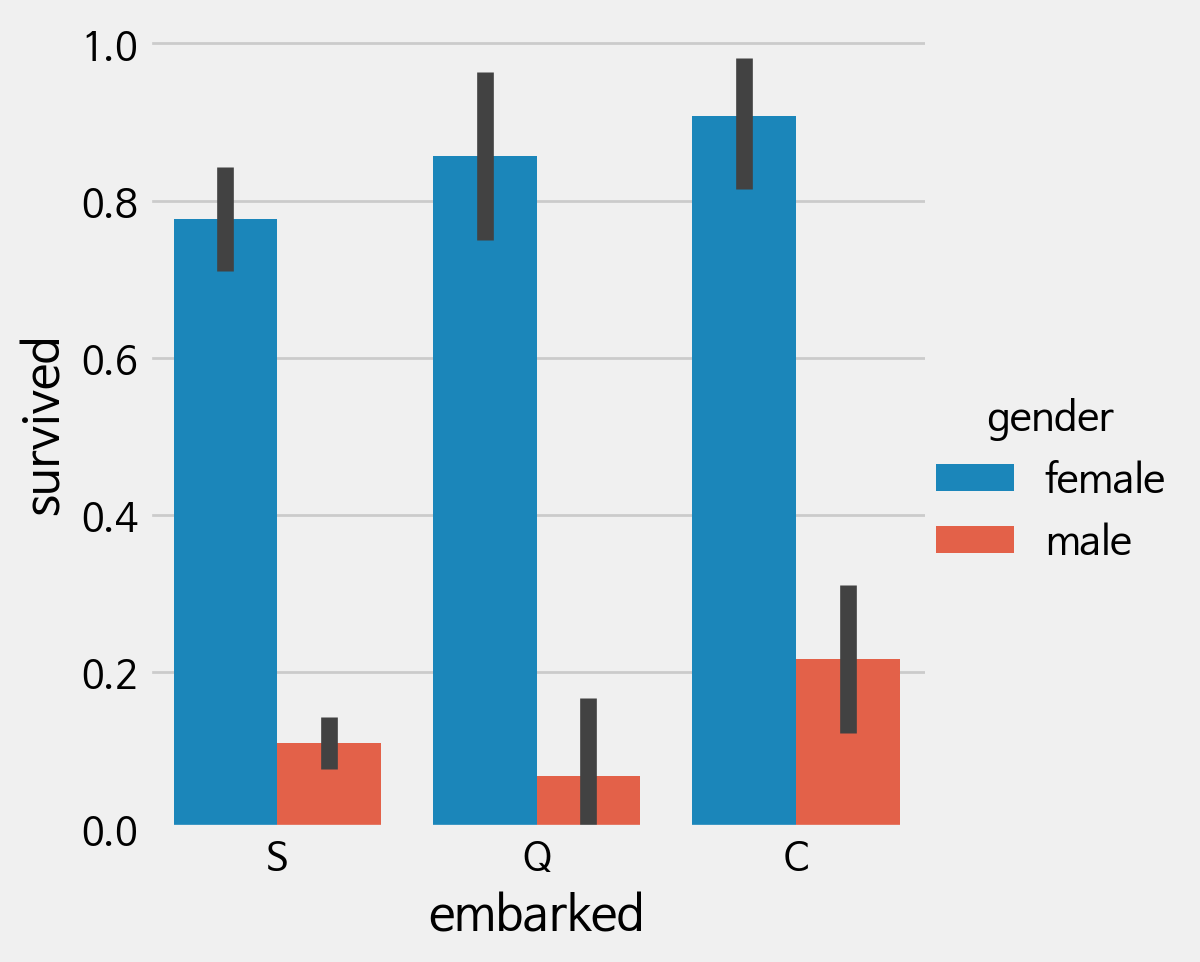

In [63]:
sns.catplot(data=train, x="embarked", y="survived", hue="gender", kind="bar")

### text features

In [64]:
text_cols = ['name', 'ticket']
train[text_cols].head()

,name,ticket
812,"Ohman, Miss. Velin",347085
134,"Buckley, Mr. Daniel",330920
390,"Jonsson, Mr. Carl",350417
305,"Hassan, Mr. Houssein G N",2699
203,"Corn, Mr. Harry",SOTON/OQ 392090


add Initial_name

In [65]:
for df in [train, test, ori_te]:
  df['Initial_name'] = df['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
  df.drop(['name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

add Initial_name_type

In [66]:
train['Initial_name'].unique()

array(['Miss', 'Mr', 'Mrs', 'Master', 'Dr', 'Rev', 'Capt', 'Mlle', 'Ms',
       'Col', 'Major', 'Sir', 'Jonkheer'], dtype=object)

In [67]:
train['Initial_name'].value_counts()

,count
Initial_name,
Mr,370
Miss,126
Mrs,106
Master,22
Rev,4
Dr,3
Col,3
Major,2
Capt,1


In [68]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}


def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass
  return result

for df in [train, test, ori_te]:
  df['Initial_name_type'] = df['Initial_name'].map(lambda x: add_initial_name_type(x))
  df.drop(['Initial_name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape


((641, 18), (275, 18), (393, 17))

add len_ticket

In [69]:
for df in [train, test, ori_te]:
  df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
  df.drop(['ticket'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

((641, 18), (275, 18), (393, 17))

### datetime features

## Missing Value

In [70]:
(train.isnull() / train.shape[0]).sum().sort_values(ascending=False)

,0
age,0.201248
survived,0.000000
gender_pclass,0.000000
Initial_name_type,0.000000
parch_male,0.000000
sibsp_male,0.000000
reversed_pclass,0.000000
gender_parch,0.000000
gender_sibsp,0.000000
gender_infant,0.000000


In [71]:
(test.isnull() / test.shape[0]).sum().sort_values(ascending=False)

,0
age,0.185455
embarked,0.003636
survived,0.000000
gender_pclass,0.000000
Initial_name_type,0.000000
parch_male,0.000000
sibsp_male,0.000000
reversed_pclass,0.000000
gender_parch,0.000000
gender_sibsp,0.000000


In [72]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

,0
age,0.211196
fare,0.002545
embarked,0.002545
pclass,0.000000
gender_sibsp,0.000000
Initial_name_type,0.000000
parch_male,0.000000
sibsp_male,0.000000
reversed_pclass,0.000000
gender_parch,0.000000


In [73]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1):

      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling

        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)

      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [74]:
add_cols_cleaning(train, test, ori_te)

cols_cleaning: ['embarked', 'fare', 'age']
p_train: 0 / p_test: 0 / p_ori_te: 0


## Scaling

In [75]:
from sklearn.preprocessing import StandardScaler

In [76]:
train.columns

Index(['survived', 'pclass', 'gender', 'sibsp', 'parch', 'embarked', 'infant',
       'gender_infant', 'gender_pclass', 'gender_sibsp', 'gender_parch',
       'reversed_pclass', 'sibsp_male', 'parch_male', 'Initial_name_type',
       'len_ticket', 'fare_cleaning', 'age_cleaning'],
      dtype='object')

In [77]:
scaling_cols = ['age_cleaning', 'fare_cleaning']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled,
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0 / 0 / 0


((641, 18), (275, 18), (393, 17))

## Encoding

In [78]:
from sklearn.preprocessing import OneHotEncoder

In [79]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pclass             641 non-null    int64  
 1   parch              641 non-null    int64  
 2   infant             641 non-null    int64  
 3   gender_sibsp       641 non-null    object 
 4   sibsp              641 non-null    int64  
 5   sibsp_male         641 non-null    bool   
 6   Initial_name_type  641 non-null    object 
 7   survived           641 non-null    int64  
 8   len_ticket         641 non-null    int64  
 9   embarked           641 non-null    object 
 10  gender_pclass      641 non-null    object 
 11  gender_infant      641 non-null    object 
 12  gender             641 non-null    object 
 13  reversed_pclass    641 non-null    int64  
 14  parch_male         641 non-null    bool   
 15  gender_parch       641 non-null    object 
 16  age_cleaning       641 non

In [80]:
for df in [train, test, ori_te]:
  df['sibsp_male'] = df['sibsp_male'].astype("int32")
  df['parch_male'] = df['parch_male'].astype("int32")

In [81]:
train.head()

,pclass,parch,infant,gender_sibsp,sibsp,sibsp_male,Initial_name_type,survived,len_ticket,embarked,gender_pclass,gender_infant,gender,reversed_pclass,parch_male,gender_parch,age_cleaning,fare_cleaning
0,3,0,0,female_0,0,0,Others,1,1,S,female_3,female_0,female,1,0,female_0,-0.586811,-0.479616
1,3,0,0,male_0,0,0,Others,0,1,Q,male_3,male_0,male,1,0,male_0,-0.654810,-0.478696
2,3,0,0,male_0,0,0,Others,1,1,S,male_3,male_0,male,1,0,male_0,0.093175,-0.478025
3,3,0,0,male_0,0,0,Others,0,1,C,male_3,male_0,male,1,0,male_0,-1.334796,-0.258431
4,3,0,0,male_0,0,0,Others,0,2,S,male_3,male_0,male,1,0,male_0,-0.042822,-0.474092


In [82]:
train.select_dtypes(exclude=np.number)

,gender_sibsp,Initial_name_type,embarked,gender_pclass,gender_infant,gender,gender_parch
0,female_0,Others,S,female_3,female_0,female,female_0
1,male_0,Others,Q,male_3,male_0,male,male_0
2,male_0,Others,S,male_3,male_0,male,male_0
3,male_0,Others,C,male_3,male_0,male,male_0
4,male_0,Others,S,male_3,male_0,male,male_0
...,...,...,...,...,...,...,...
636,female_0,Others,S,female_2,female_0,female,female_0
637,female_0,Others,Q,female_3,female_0,female,female_0
638,male_0,Others,S,male_1,male_0,male,male_0
639,male_2,Officer,S,male_3,male_1,male,male_1


In [83]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder()
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(),
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

len_enc_cols: 7
0 / 0 / 0


((641, 39), (275, 39), (393, 38))

## Modeling

In [84]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [85]:
train.shape, test.shape, ori_te.shape

((641, 39), (275, 39), (393, 38))

In [86]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((641, 38), (641,), (275, 38), (275,))

In [87]:
from sklearn.ensemble import StackingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost  import CatBoostClassifier

In [88]:
SEED = 22
estimators = [
    ( "mlp" , MLPClassifier(max_iter=1000,random_state=SEED) ),
    ( "lr" , LogisticRegression(random_state=SEED) ),
    ( "rf" , RandomForestClassifier(random_state=SEED) )
]

hp = {
    "estimators" : estimators,
    "final_estimator" : LogisticRegression(random_state=SEED)
}

modelV5 = StackingClassifier(**hp,n_jobs=-1)
modelV5.fit(X_tr, y_tr)
print(f'훈련용 평가지표: {modelV5.score(X_tr, y_tr)} / 테스트용 평가지표: {modelV5.score(X_te, y_te)}')

훈련용 평가지표: 0.890795631825273 / 테스트용 평가지표: 0.8654545454545455


## Modeling2

In [88]:
!pip install pycaret[full]

  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3


In [89]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

In [90]:
from pycaret.classification import *

exp_clf = setup(data = train, target = 'survived', session_id=123)

ImportError: cannot import name '_Scorer' from 'sklearn.metrics._scorer' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py)

In [ ]:
best_model = compare_models()

## Pipeline

In [89]:
# 필수 라이브러리
!pip install --upgrade joblib==1.1.0
!pip install --upgrade scikit-learn==1.1.3
!pip install mglearn

# 한글깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [90]:
import logging

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [97]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [92]:
from sklearn.pipeline import Pipeline

In [93]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svm', SVC())
])

In [94]:
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [95]:
pipe.score(X_te, y_te)

0.8763636363636363

In [99]:
param_grid = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid.fit(X_tr, y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [100]:
grid.best_score_

0.8627180232558139

In [101]:
grid.best_params_

{'svm__C': 0.1, 'svm__gamma': 1}

In [104]:
grid.score(X_te, y_te)

0.8254545454545454

In [105]:
from sklearn import set_config
set_config(display='diagram')

In [106]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Evaluation

In [ ]:
score_tr = modelV5.score(X_tr, y_tr)
score_te = modelV5.score(X_te, y_te)

score_tr, score_te

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = modelV5.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

In [ ]:
ori_te_pred = modelV5.predict_proba(ori_te)[:,1]
ori_te_pred.shape

In [ ]:
# df_feature_importances = pd.DataFrame(modelV5.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

# print(f'{df_feature_importances.shape}')
# df_feature_importances

In [ ]:
args.results.append(
    {
        'model': 'modelV5',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        # 'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False).reset_index(drop=True)




```
# 코드로 형식 지정됨
```

# ModelV6

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(ori_tr, test_size=0.3, stratify=ori_tr['survived'], random_state=args.random_state)

train.shape, test.shape

- cabin: 학습에 도움이 안됨!!, 삭제 필요!!

In [ ]:
train.drop('cabin', axis=1, inplace=True)
test.drop('cabin', axis=1, inplace=True)
ori_te.drop('cabin', axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

## Feature Extraction with EDA

In [ ]:
train.info()

### continous features

In [ ]:
continous_cols = ['age', 'fare'] + ['survived']

train[continous_cols].describe()

In [ ]:
train[continous_cols].corr()

age

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

add infant

In [ ]:
def add_infant(age):
  result = 0
  try:
    if age <= 5:
      result = 1
  except:
    pass
  return result

train['infant'] = train['age'].map(lambda x: add_infant(x))
test['infant'] = test['age'].map(lambda x: add_infant(x))
ori_te['infant'] = ori_te['age'].map(lambda x: add_infant(x))

print(f"{train['infant'].nunique()} / \n {train['infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

add gender_infant

In [ ]:
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"{train['gender_infant'].nunique()} / \n {train['gender_infant'].unique()} \n")
train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass")

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

add gender_pclass

In [ ]:
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"{train['gender_pclass'].nunique()} / \n {train['gender_pclass'].unique()} \n")
train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

add gender_sibsp

In [ ]:
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass
  return result

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"{train['gender_sibsp'].nunique()} / \n {train['gender_sibsp'].unique()} \n")
train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

add gender_parch

In [ ]:
train['parch'].unique()

In [ ]:
train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"{train['gender_parch'].nunique()} / \n {train['gender_parch'].unique()} \n")
train.shape, test.shape, ori_te.shape

fare

In [ ]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
train.columns

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

### ordinal features

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch'] + ['survived']

train[ordinal_cols].describe()

In [ ]:
train[ordinal_cols].corr()

add reversed_pclass

In [ ]:
train['reversed_pclass'] = train['pclass'].map(lambda x: 4 - int(x))
test['reversed_pclass'] = test['pclass'].map(lambda x: 4 - int(x))
ori_te['reversed_pclass'] = ori_te['pclass'].map(lambda x: 4 - int(x))

train[ordinal_cols+['reversed_pclass']].corr()

In [ ]:
sns.catplot(data=train, x="sibsp", y="survived", hue="gender", kind="bar")

In [ ]:
c1 = train['sibsp'] == 8
c2 = train['gender'] == 'female'
c = c1 & c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['sibsp'] >= 2
c2 = train['gender'] == 'male'
c = c1 & c2
train.loc[c]['survived'].mean()

add sibsp_male

In [ ]:
for df in [train, test, ori_te]:
  c1 = df['sibsp'] >= 2
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['sibsp_male'] = c

train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(ori_tr, x="sibsp", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
train.columns

In [ ]:
sns.catplot(data=train, x="parch", y="survived", hue="gender", kind="bar")

In [ ]:
c1 = train['gender'] == 'male'
c2 = train['parch'] >= 3
c = c1 & c2
train.loc[c]['survived'].mean()

add parch_male

In [ ]:
for df in [train, test, ori_te]:
  c1 = df['parch'] >= 3
  c2 = df['gender'] == 'male'
  c = c1 & c2
  df['parch_male'] = c

train.shape, test.shape, ori_te.shape

In [ ]:
sns.displot(train, x="parch", hue="survived", multiple="dodge", bins=20, col="pclass", row="gender")

In [ ]:
sns.catplot(data=train, x="pclass", y="survived", hue="gender", kind="bar")

### categorical features

In [ ]:
train.columns

In [ ]:
categorical_cols = ['gender', 'embarked'] + ['survived']
train[categorical_cols].describe(include='all')

In [ ]:
sns.catplot(data=train, x="gender", y="survived", hue="embarked", kind="bar")

In [ ]:
sns.catplot(data=train, x="embarked", y="survived", hue="gender", kind="bar")

### text features

In [ ]:
text_cols = ['name', 'ticket']
train[text_cols].head()

add Initial_name

In [ ]:
for df in [train, test, ori_te]:
  df['Initial_name'] = df['name'].str.extract('([A-Za-z]+)\.') #lets extract the Salutations
  df.drop(['name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

add Initial_name_type

In [ ]:
train['Initial_name'].unique()

In [ ]:
train['Initial_name'].value_counts()

In [ ]:
dict_initial_name = {
    'Mr': 'Others',
    'Miss': 'Others',
    'Mrs': 'Others',

    'Master': 'Officer',
    'Rev': 'Officer',
    'Dr': 'Officer',
    'Col': 'Officer',
    'Major': 'Officer',
    'Capt': 'Officer',

    'Jonkheer': 'Royalty',
    'Countess': 'Royalty',
    'Sir': 'Royalty'
}


def add_initial_name_type(initial_name):
  result = 'Others'
  try:
    result = dict_initial_name[initial_name]
  except:
    pass
  return result

for df in [train, test, ori_te]:
  df['Initial_name_type'] = df['Initial_name'].map(lambda x: add_initial_name_type(x))
  df.drop(['Initial_name'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape


add len_ticket

In [ ]:
for df in [train, test, ori_te]:
  df['len_ticket'] = df['ticket'].map(lambda x: len(x.strip().split(' ')))
  df.drop(['ticket'], axis=1, inplace=True)

train.shape, test.shape, ori_te.shape

### datetime features

## Missing Value

In [ ]:
(train.isnull() / train.shape[0]).sum().sort_values(ascending=False)

In [ ]:
(test.isnull() / test.shape[0]).sum().sort_values(ascending=False)

In [ ]:
(ori_te.isnull() / ori_te.shape[0]).sum().sort_values(ascending=False)

In [ ]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def __get_cols_cleaning(p_pd_list:list) -> list:
  cols_cleaning = []
  for df in p_pd_list:
    # 결측치 컬럼 조회
    tmp = df.isnull().sum()
    cols_cleaning += list(tmp[df.isnull().sum() > 0].index)

  cols_cleaning = list(set(cols_cleaning))
  print(f'cols_cleaning: {cols_cleaning}')
  return cols_cleaning

def add_cols_cleaning(p_train:pd.DataFrame, p_test:pd.DataFrame, p_ori_te:pd.DataFrame) -> None:
  pd_list = [p_train, p_test, p_ori_te]
  for col in __get_cols_cleaning(pd_list):  # for col in cols_cleaning:
    for i, df in enumerate(pd_list, start=1):

      if is_numeric_dtype(df[col]): # 숫자형 결측치 처리
        new_col = col+'_cleaning'
        df[new_col] = df[col]
        # random sampling
        random_sampling = (p_train[col].dropna().sample(df[col].isnull().sum()))
        # index 부여
        random_sampling.index = df[lambda x: x[col].isnull()].index
        # NA imputation
        df.loc[df[col].isnull(), new_col] = random_sampling

        # 기존 결측치 컬럼 제거
        if i == len(pd_list):
          for _df in pd_list:
            _df.drop([col], axis=1, inplace=True)

      else: # 범주형 결측치 처리
        df[col].fillna(p_train[col].mode().values[0], inplace=True)

  print(f'p_train: {p_train.isnull().sum().sum()} / p_test: {p_test.isnull().sum().sum()} / p_ori_te: {p_ori_te.isnull().sum().sum()}')


In [ ]:
add_cols_cleaning(train, test, ori_te)

## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train.columns

In [ ]:
scaling_cols = ['age_cleaning', 'fare_cleaning']
scaler = StandardScaler()
scaled_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _scaled = scaler.fit_transform(df[scaling_cols])
  else:
    _scaled = scaler.transform(df[scaling_cols])

  _scaled_df = pd.DataFrame(
    _scaled,
    columns = scaling_cols
  )

  not_scaling_cols = list(set(df.columns) - set(scaling_cols))

  scaled_dfs.append(
    pd.concat(
      [df[not_scaling_cols].reset_index(drop=True), _scaled_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = scaled_dfs[0]
test = scaled_dfs[1]
ori_te = scaled_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

## Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
train.info()

In [ ]:
for df in [train, test, ori_te]:
  df['sibsp_male'] = df['sibsp_male'].astype("int32")
  df['parch_male'] = df['parch_male'].astype("int32")

In [ ]:
train.head()

In [ ]:
train.select_dtypes(exclude=np.number)

In [ ]:
enc_cols = list(train.select_dtypes(exclude=np.number).columns)
print(f'len_enc_cols: {len(enc_cols)}')
encoder = OneHotEncoder()
enc_dfs = []

for i, df in enumerate([train, test, ori_te]):
  if not i:
    _encoded = encoder.fit_transform(df[enc_cols])
  else:
    _encoded = encoder.transform(df[enc_cols])

  _encoded_df = pd.DataFrame(
    _encoded.toarray(),
    columns = encoder.get_feature_names_out()
  )

  not_enc_cols = list(set(df.columns) - set(enc_cols))
  enc_dfs.append(
    pd.concat(
      [df[not_enc_cols].reset_index(drop=True), _encoded_df.reset_index(drop=True)]
      , axis=1
    ).reset_index(drop=True)
  )

train = enc_dfs[0]
test = enc_dfs[1]
ori_te = enc_dfs[2]

print(f'{train.isnull().sum().sum()} / {test.isnull().sum().sum()} / {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

## Modeling

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

In [ ]:
from sklearn.ensemble import StackingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
SEED = 22
estimators = [
    ( "mlp" , MLPClassifier(max_iter=1000,random_state=SEED) ),
    ( "lr" , LogisticRegression(random_state=SEED) ),
    ( "rf" , RandomForestClassifier(random_state=SEED) )
]

hp = {
    "estimators" : estimators,
    "final_estimator" : LogisticRegression(random_state=SEED)
}

modelV5 = StackingClassifier(**hp,n_jobs=-1)
modelV5.fit(X_tr, y_tr)
print(f'훈련용 평가지표: {modelV5.score(X_tr, y_tr)} / 테스트용 평가지표: {modelV5.score(X_te, y_te)}')

## Evaluation

In [ ]:
score_tr = modelV5.score(X_tr, y_tr)
score_te = modelV5.score(X_te, y_te)

score_tr, score_te

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = modelV5.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te,y_pred)
auc_te = auc(fpr, tpr)
print(f'model: {auc_te}')

In [ ]:
ori_te_pred = modelV5.predict_proba(ori_te)[:,1]
ori_te_pred.shape

In [ ]:
# df_feature_importances = pd.DataFrame(modelV5.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

# print(f'{df_feature_importances.shape}')
# df_feature_importances

In [ ]:
args.results.append(
    {
        'model': 'modelV5',
        'score_tr': score_tr,
        'score_te': score_te,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        # 'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': '0220'
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False).reset_index(drop=True)


# Submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False).reset_index(drop=True)
df_results

In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

In [ ]:
df_results.head()

In [ ]:
submission['survived'] = df_results.loc[0, ['ori_te_pred']].values[0]
print(f'{submission.isnull().sum().sum()}')
submission.head(10)

In [ ]:
submission.to_csv(args.default_path+'result/submission_v3.csv', header=True, index=False)

In [ ]:
# submission['survived'] = df_results.loc[4, ['ori_te_pred']].values[0]
# submission.to_csv(args.default_path+'result/submission_v4.csv', header=True, index=False)

# Save Results

In [ ]:
df_results.drop(['ori_te_pred'], axis=1, inplace=True)
df_results

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
import json

load_results = None
with open(args.save_results, 'r') as file:
    load_results = json.load(file)

len(load_results)